
SixHumpCamel: 2D


In [1]:
pip install pyGPGO


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 4.0 MB/s 
     |████████████████████████████████| 872 kB 40.6 MB/s 
  Created wheel for pyGPGO: filename=pyGPGO-0.5.1-py3-none-any.whl size=19879 sha256=2321891f9bd48d1263023073d5904e9f921afe634e1d84ae7c9b4dcf2f12e91e
  Stored in directory: /root/.cache/pip/wheels/c8/5d/0b/2160114e2f1b87791c51b66cf07f89831dbb6f49167950316f
  Created wheel for Theano-PyMC: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529963 sha256=11ec211ada3d884291b1e5f950006cfdba31acece5877771a56ae806a056ed96
  Stored in directory: /root/.cache/pip/wheels/f3/af/8c/5dd7553522d74c52a7813806fc7ee1a9caa20a3f7c8fd850d5
Successfully built pyGPGO Theano-PyMC


In [2]:
### Import:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import itertools

from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from joblib import Parallel, delayed
from numpy.linalg import solve, cholesky
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
from scipy.stats import norm
import time

warnings.filterwarnings("ignore", category=RuntimeWarning)


In [3]:
### Inputs:

func = 'SixHumpCamel'
n_test = 500
eps = 1e-08

util = 'CBM'

n_init = 5 # random initialisations
iters = 20
opt = True

In [4]:
### Objective Function - SixHumpCamel(x) 2-D:

def objfunc(x1_training, x2_training):
        return operator * ((4 - 2.1 * x1_training ** 2 + 1 / 3 * x1_training ** 4) * x1_training ** 2 +
                (x1_training * x2_training) + (-4 + 4 * x2_training ** 2) * x2_training ** 2)
    
# Constraints:
lb_x1 = -3
ub_x1 = +3
    
lb_x2 = -2
ub_x2 = +2

# Input array dimension(s):
dim = 2

# 2-D inputs' parameter bounds:
param = {'x1_training': ('cont', [lb_x1, ub_x1]),
             'x2_training': ('cont', [lb_x2, ub_x2])}

# True y bounds:
operator = -1
y_global_orig = -1.0316 # targets global minimum

# Test data:
x1_test = np.linspace(lb_x1, ub_x1, n_test) 
x2_test = np.linspace(lb_x2, ub_x2, n_test)
  
x_test = np.column_stack((x1_test,x2_test))


In [5]:
n_start_AcqFunc = iters
inverse = -1


In [6]:
### Cumulative Regret Calculators:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list
  
def acqFuncExact(x):
    new_array = []
    x = np.array(x) 
    for i, num in enumerate(x):
            new_array = x[:-2][::-3]
    return new_array[::-1]

def acqFuncApprox(x):
    new_array = []
    x = np.array(x) 
    for i, num in enumerate(x):
            new_array = x[:-1][::-3]
    return new_array[::-1]


In [7]:
### Surrogate derivatives: 

cov_func = squaredExponential()

def kronDelta(X, Xstar):                     # Kronecker's Delta method
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):         # S.E. kernel method
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def delta(X, Xstar):                         # Distance between training X and test Xstar vectors
    return (X - Xstar)
   
def der_covmat(X, Xstar, sigmaf, l, sigman): # Covariance matrix derivative terms (i.e. exact, first-order)
    nx = len(X)
    ny = len(Xstar)
    return np.round(np.array([(delta(np.atleast_2d(i), np.atleast_2d(j))[0] * se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman)[0]).sum() for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dGaussianProcess(GaussianProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE
    
    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the GP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T
        
        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        alpha_Kstar = np.dot(np.linalg.inv(self.K + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)
        
        dm = np.dot(dKstar, self.alpha)
        ds = -2 * np.dot(dKstar, alpha_Kstar)
        
        return dm, ds           


In [8]:
### Add exact acquisition function gradient as attribute:

Beta_CBM = dim

class Acquisition_grad(Acquisition):    
    def __init__(self, mode, eps=eps, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'CBM': self.CBM
        }

        self.f = mode_dict[mode]
    
    def CBM(self, y_global_orig, mean, std, ds, dm):
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        gamma_h = (mean - y_global_orig) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)

        f = (std + self.eps) * (gamma + np.sqrt(Beta_CBM))
        df = dsdx * (gamma + np.sqrt(Beta_CBM)) + (std + self.eps) * dmdx
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()
        
    def d_eval(self, y_global_orig, mean, std, ds, dm):
    
        return self.f(y_global_orig, mean, std, ds, dm, **self.params)
        

In [9]:
## GPGO_multi: 

class GPGO_multi(GPGO):
    n_start = n_start_AcqFunc

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t        Exact CBM: StdDev. x \t Approx CBM: StdDev. x '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'
 
    def acqfuncExact(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(y_global_orig, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df
   
    def acqfuncApprox(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(y_global_orig, new_mean, new_std, ds=ds, dm=dm)

        return -f
   
    def _optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.x_best_std = np.std(x_best)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr        
        self.history.append(self.x_best_std)

        x_best_exact = np.empty((n_start, len(self.parameter_key)))
        f_best_exact = np.empty((n_start,))
        opt_exact = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best_exact = np.array([res.x for res in opt_exact])
        f_best_exact = np.array([np.atleast_1d(res.fun)[0] for res in opt_exact])
        f_best_min_exact = min(f_best_exact)

        self.x_best_exact = x_best_exact
        self.f_best_exact = f_best_exact
        self.f_best_min_exact = f_best_min_exact
        self.x_best_std_exact = np.std(x_best_exact)
        self.best_exact = x_best_exact[np.argmin(f_best_exact)]
        self.start_points_arr = start_points_arr
        self.history.append(self.x_best_std_exact)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfunc = str(self.f_best_min)
        min_acqfunc_exact = str(self.f_best_min_exact)
        x_best_std = str(self.x_best_std)
        x_best_std_exact = str(self.x_best_std_exact)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            x_best_std = BOLD + OKGREEN + x_best_std + ENDC
            x_best_std_exact = BOLD + OKGREEN + x_best_std_exact + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, x_best_std_exact, x_best_std))
        
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [10]:
## dGPGO:

class dGPGO(GPGO):
    n_start = n_start_AcqFunc

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t        Exact CBM: StdDev. x \t Approx CBM: StdDev. x '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'

    def acqfuncExact(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(y_global_orig, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df
   
    def acqfuncApprox(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(y_global_orig, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def d_optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.x_best_std = np.std(x_best)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.history.append(self.x_best_std)

        x_best_approx = np.empty((n_start, len(self.parameter_key)))
        f_best_approx = np.empty((n_start,))
        opt_approx = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best_approx = np.array([res.x for res in opt_approx])
        f_best_approx = np.array([np.atleast_1d(res.fun)[0] for res in opt_approx])
        f_best_min_approx = min(f_best_approx)

        self.x_best_approx = x_best_approx
        self.f_best_approx = f_best_approx
        self.f_best_min_approx = f_best_min_approx
        self.x_best_std_approx = np.std(x_best_approx)
        self.best_approx = x_best_approx[np.argmin(f_best_approx)]
        self.start_points_arr = start_points_arr
        self.history.append(self.x_best_std_approx)
    
    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfunc = str(self.f_best_min)
        min_acqfunc_approx = str(self.f_best_min_approx)
        x_best_std = str(self.x_best_std)
        x_best_std_approx = str(self.x_best_std_approx)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            x_best_std = BOLD + OKGREEN + x_best_std + ENDC
            x_best_std_approx = BOLD + OKGREEN + x_best_std_approx + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, x_best_std, x_best_std_approx))

    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [11]:
###Reproducible set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [12]:
start_approx = time.time()
start_approx


1663241728.540393

In [13]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_1)
surrogate_approx_1 = dGaussianProcess(cov_func, optimize=opt)

approx_1 = GPGO_multi(surrogate_approx_1, Acquisition_grad(util), objfunc, param)
approx_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-0.49786797  0.88129797]	 -0.2650082867644827	 -0.2650082867644827	    	    
init	 [-2.99931375 -0.79066971]	 110.13991869176735	 -0.2650082867644827	    	    
init	 [-2.11946466 -1.63064562]	 26.90935479429681	 -0.2650082867644827	    	    
init	 [-1.88243873 -0.61775709]	 2.8558363102363344	 -0.2650082867644827	    	    
init	 [-0.61939515  0.15526694]	 1.0540522096005847	 -0.2650082867644827	    	    
1  	 [-1.18606724 -0.32730868]	 2.404769662408658	 -0.2650082867644827	 1.780267227566921	 1.8723403745339924
2  	 [-0.19390254  1.86395485]	 34.17251657475824	 -0.2650082867644827	 1.2786537924315626	 1.3846596574311536
3  	 [-1.45382908  0.57603439]	 0.4961054636741006	 -0.2650082867644827	 1.8963140594357943	 2.0736341632087005
4  	 [ 3. -2.]	 150.89999999999998	 -0.2650082867644827	 1.9465959443051573	 2.07239603723599
5  	 [3. 2.]	 162.89999999999998	 -0.2650082

In [14]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_2)
surrogate_approx_2 = dGaussianProcess(cov_func, optimize=opt)

approx_2 = GPGO_multi(surrogate_approx_2, Acquisition_grad(util), objfunc, param)
approx_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-0.38403059 -1.89629507]	 38.61280125654363	 0.011939608840498828	    	    
init	 [ 0.29797487 -0.25871043]	 0.011939608840498828	 0.011939608840498828	    	    
init	 [-0.47779319 -0.67866072]	 0.1381453419305213	 0.011939608840498828	    	    
init	 [-1.7721082   0.47708387]	 0.626144759281101	 0.011939608840498828	    	    
init	 [-1.20207196 -0.9326909 ]	 3.0693811601417798	 0.011939608840498828	    	    
1  	 [-0.44944718  0.00412019]	 0.7231482101785051	 0.011939608840498828	 1.8687801931790096	 1.9863982629593389
2  	 [3.         1.11315799]	 113.42467167858395	 0.011939608840498828	 1.5230877775556604	 1.7848510341825166
3  	 [ 3. -2.]	 150.89999999999998	 0.011939608840498828	 1.709510814702826	 2.2004045593566337
4	 [-0.4273653   0.45926204]	 -0.19946352694484404	 -0.19946352694484404	 1.399819451671646	 2.0827818949819434
5  	 [-0.4504636   0.39811418]	 0.

In [15]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_3)
surrogate_approx_3 = dGaussianProcess(cov_func, optimize=opt)

approx_3 = GPGO_multi(surrogate_approx_3, Acquisition_grad(util), objfunc, param)
approx_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [0.30478742 0.83259129]	 -0.2431922946563294	 -0.2431922946563294	    	    
init	 [-1.25457157  0.04331042]	 2.3313310458730996	 -0.2431922946563294	    	    
init	 [2.35768173 1.58517236]	 33.54152175045586	 -0.2431922946563294	    	    
init	 [-2.24648814 -1.17102849]	 14.214109412296352	 -0.2431922946563294	    	    
init	 [-2.69119678 -0.23676063]	 45.87579771712209	 -0.2431922946563294	    	    
1  	 [-0.17346461  0.09867865]	 0.0627797266162901	 -0.2431922946563294	 1.612648998938329	 1.5921389141990647
2  	 [-0.54021506  1.28385489]	 4.577426358133429	 -0.2431922946563294	 1.6141930375367233	 2.341995538175061
3	 [ 0.22078911 -0.76717581]	 -0.9479738764036132	 -0.9479738764036132	 1.4948573679665222	 1.7919849329051931
4  	 [ 0.7324259  -1.32648994]	 5.96748668565785	 -0.9479738764036132	 1.4086453294883585	 1.1613582582714577
5  	 [ 3. -2.]	 150.89999999999998

In [16]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_4)
surrogate_approx_4 = dGaussianProcess(cov_func, optimize=opt)

approx_4= GPGO_multi(surrogate_approx_4, Acquisition_grad(util), objfunc, param)
approx_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [2.80217903 0.188929  ]	 63.70212732873661	 2.3196402150601703	    	    
init	 [2.83610616 0.85926397]	 71.43837110827245	 2.3196402150601703	    	    
init	 [ 1.18637295 -1.13564202]	 2.5463267765341566	 2.3196402150601703	    	    
init	 [ 2.85764673 -1.97507898]	 113.76785286351424	 2.3196402150601703	    	    
init	 [-1.48210583 -0.26083387]	 2.3196402150601703	 2.3196402150601703	    	    
1	 [ 0.11144461 -1.106195  ]	 1.0208547187686163	 1.0208547187686163	 1.577257508311141	 2.0019383618452062
2  	 [-3.  2.]	 150.89999999999998	 1.0208547187686163	 1.8321124647696423	 2.1601436541533747
3	 [ 0.12887647 -0.95580402]	 -0.3731899878542085	 -0.3731899878542085	 2.1092385170747705	 1.3803231236978135
4  	 [-3. -2.]	 162.89999999999998	 -0.3731899878542085	 1.9839607627783045	 1.2876788964470105
5  	 [-0.25741376 -0.09920887]	 0.24247965331112298	 -0.3731899878542085

In [17]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_5)
surrogate_approx_5 = dGaussianProcess(cov_func, optimize=opt)

approx_5 = GPGO_multi(surrogate_approx_5, Acquisition_grad(util), objfunc, param)
approx_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-1.66804097  1.48292922]	 10.126030408244933	 -0.6512780061070701	    	    
init	 [-1.75968507  1.67444363]	 19.4300499315822	 -0.6512780061070701	    	    
init	 [-0.06953287  0.44697545]	 -0.6512780061070701	 -0.6512780061070701	    	    
init	 [1.59544714 0.07367195]	 2.168775388880503	 -0.6512780061070701	    	    
init	 [-1.21919699 -1.24911509]	 7.420330936884148	 -0.6512780061070701	    	    
1  	 [0.46777833 1.31550202]	 6.450542021076657	 -0.6512780061070701	 1.9646927451771634	 2.257808012331222
2  	 [ 3. -2.]	 150.89999999999998	 -0.6512780061070701	 2.023092969085543	 2.420743687382041
3  	 [3. 2.]	 162.89999999999998	 -0.6512780061070701	 2.3290594292645688	 2.1378074893431265
4  	 [ 0.46969203 -0.2305661 ]	 0.47418268969959676	 -0.6512780061070701	 1.2954965981150046	 1.7355105542932359
5  	 [-3. -2.]	 162.89999999999998	 -0.6512780061070701	 1.29304469

In [18]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_6)
surrogate_approx_6 = dGaussianProcess(cov_func, optimize=opt)

approx_6 = GPGO_multi(surrogate_approx_6, Acquisition_grad(util), objfunc, param)
approx_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 2.35716091 -0.67208078]	 11.995980169715628	 -0.3096187466378422	    	    
init	 [ 1.92737474 -1.8332135 ]	 31.167927894156623	 -0.3096187466378422	    	    
init	 [-2.35405992  0.38020826]	 13.013381745677465	 -0.3096187466378422	    	    
init	 [ 0.17890417 -0.32477029]	 -0.3096187466378422	 -0.3096187466378422	    	    
init	 [-0.9875529   0.49007773]	 0.9989196280666852	 -0.3096187466378422	    	    
1  	 [0.26547548 1.08519505]	 1.3965163372549376	 -0.3096187466378422	 2.0348476733877763	 1.679911753812162
2  	 [3. 2.]	 162.89999999999998	 -0.3096187466378422	 2.24819344450352	 2.174160276873216
3  	 [-1.21989026 -2.        ]	 52.84028883725318	 -0.3096187466378422	 1.4959883980053323	 1.7316463617700601
4	 [-0.03743054  0.52283304]	 -0.808496932340479	 -0.808496932340479	 1.5917599610507707	 1.7580510464634738
5	 [-0.03761397  0.52298634]	 -0.8088342175755464	

In [19]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_7)
surrogate_approx_7 = dGaussianProcess(cov_func, optimize=opt)

approx_7 = GPGO_multi(surrogate_approx_7, Acquisition_grad(util), objfunc, param)
approx_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-2.54215026  1.11967517]	 26.53843863832488	 -0.46481072558790276	    	    
init	 [-0.36954461  0.89386071]	 -0.46481072558790276	 -0.46481072558790276	    	    
init	 [2.86793707 0.15398348]	 76.66051064695093	 -0.46481072558790276	    	    
init	 [ 0.00672278 -1.71179547]	 22.613010892757885	 -0.46481072558790276	    	    
init	 [-1.38936612e+00 -4.69996698e-04]	 2.294585534557751	 -0.46481072558790276	    	    
1  	 [0.18555601 1.87792631]	 36.12511379202412	 -0.46481072558790276	 2.0747857390452666	 1.9729968538674647
2  	 [-2.0069916  -0.34039291]	 4.09787808897999	 -0.46481072558790276	 1.476826716896781	 1.476826716896781
3  	 [-0.25767452  0.4088046 ]	 -0.40568088405519975	 -0.46481072558790276	 2.0276935770661755	 2.1176316008762335
4  	 [-0.76527744  0.76664994]	 0.13338714669592067	 -0.46481072558790276	 1.8153999082013315	 1.9643715063703973
5  	 [0.36644

In [20]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_8)
surrogate_approx_8 = dGaussianProcess(cov_func, optimize=opt)

approx_8 = GPGO_multi(surrogate_approx_8, Acquisition_grad(util), objfunc, param)
approx_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [2.24057642 1.87416265]	 48.82879577505094	 0.03190064766213015	    	    
init	 [2.21516724 0.12342277]	 8.660623551418242	 0.03190064766213015	    	    
init	 [-1.60363003 -1.95440478]	 48.28332373939171	 0.03190064766213015	    	    
init	 [-0.41718709 -0.39059456]	 0.2801229037700297	 0.03190064766213015	    	    
init	 [ 0.13604803 -0.08643282]	 0.03190064766213015	 0.03190064766213015	    	    
1  	 [-0.89741432  0.97165939]	 0.950476868191811	 0.03190064766213015	 1.3696758460478275	 1.6744929304933691
2  	 [-3.  2.]	 150.89999999999998	 0.03190064766213015	 1.4113843252571625	 2.283375336296024
3	 [-0.28588003  0.47958088]	 -0.5324330327038412	 -0.5324330327038412	 1.4048946805387292	 1.6426332034839657
4  	 [-0.29023534  0.46026491]	 -0.4792048448725873	 -0.5324330327038412	 1.6301222810004021	 2.0096571825697414
5  	 [-0.29231765  0.44859018]	 -0.447411312346

In [21]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_9)
surrogate_approx_9 = dGaussianProcess(cov_func, optimize=opt)

approx_9 = GPGO_multi(surrogate_approx_9, Acquisition_grad(util), objfunc, param)
approx_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-2.93775508  0.00749837]	 92.35857237145763	 1.395407492769129	    	    
init	 [-0.02536024 -1.46468188]	 9.867672894921913	 1.395407492769129	    	    
init	 [-2.14733349 -1.1257653 ]	 10.24680089963123	 1.395407492769129	    	    
init	 [-0.48895092 -1.00759533]	 1.395407492769129	 1.395407492769129	    	    
init	 [-2.49564209 -0.61800544]	 24.58298635463645	 1.395407492769129	    	    
1  	 [0.20131902 1.29635498]	 4.994334264333181	 1.395407492769129	 1.486286346663899	 1.4924231086599675
2  	 [ 3.         -0.22244192]	 108.04454585361225	 1.395407492769129	 2.1686338617217595	 2.112405367881905
3  	 [-1.45525499  2.        ]	 47.30820739097184	 1.395407492769129	 1.9578452863670142	 1.9139426840529408
4  	 [-1.57103971 -2.        ]	 53.23376592854789	 1.395407492769129	 2.3826972993971225	 1.6853589755931544
5  	 [1.96989474 2.        ]	 55.317245840824256	 1.3

In [22]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_10)
surrogate_approx_10 = dGaussianProcess(cov_func, optimize=opt)

approx_10 = GPGO_multi(surrogate_approx_10, Acquisition_grad(util), objfunc, param)
approx_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 1.62792386 -1.9169922 ]	 38.25414770674631	 0.7775687473184012	    	    
init	 [0.80188941 0.99521553]	 2.552651714051803	 0.7775687473184012	    	    
init	 [-0.00895793 -1.10081342]	 1.0367630165263393	 0.7775687473184012	    	    
init	 [-1.81162281  1.04212285]	 0.7775687473184012	 0.7775687473184012	    	    
init	 [-1.98533498 -1.64664074]	 25.383481436170044	 0.7775687473184012	    	    
1  	 [3. 2.]	 162.89999999999998	 0.7775687473184012	 1.6978547490176488	 1.8517943387224822
2  	 [-3.  2.]	 150.89999999999998	 0.7775687473184012	 1.4205459874112363	 2.0144208999480853
3  	 [2.55214124 0.2669997 ]	 29.488456208101837	 0.7775687473184012	 1.4572334624716674	 1.4177113447347967
4	 [-1.00040629  0.62364661]	 0.6594244604189136	 0.6594244604189136	 1.4674864481682497	 1.823805584090407
5  	 [-1.07424184  0.61547975]	 0.7292297948315574	 0.6594244604189136	 1.3

In [23]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_11)
surrogate_approx_11 = dGaussianProcess(cov_func, optimize=opt)

approx_11 = GPGO_multi(surrogate_approx_11, Acquisition_grad(util), objfunc, param)
approx_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-1.91838187 -1.92209903]	 46.39910375151002	 -0.6254688257880329	    	    
init	 [-0.22068884  0.89973572]	 -0.6254688257880329	 -0.6254688257880329	    	    
init	 [-0.47877837 -0.05829161]	 0.8249470187639529	 -0.6254688257880329	    	    
init	 [-2.92331511 -0.05051357]	 88.99028404075307	 -0.6254688257880329	    	    
init	 [2.65083991 1.40318036]	 51.423425402262914	 -0.6254688257880329	    	    
1  	 [ 1.79082137 -2.        ]	 46.642711520892725	 -0.6254688257880329	 1.4461746731163707	 1.8693091717553907
2  	 [-0.42252303  2.        ]	 47.80402340833847	 -0.6254688257880329	 0.6137731363223029	 1.5619619790230765
3  	 [ 0.10293826 -0.0075153 ]	 0.041150230437581134	 -0.6254688257880329	 1.7844656537663355	 2.0458410634952533
4  	 [ 0.08701192 -0.0033199 ]	 0.02983110872766485	 -0.6254688257880329	 1.3357991155945603	 1.7365309920705054
5  	 [ 0.07933151 -0.001

In [24]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_12)
surrogate_approx_12 = dGaussianProcess(cov_func, optimize=opt)

approx_12 = GPGO_multi(surrogate_approx_12, Acquisition_grad(util), objfunc, param)
approx_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-2.07502295  0.96019879]	 2.6185857163917037	 1.9967735906956543	    	    
init	 [-1.42010991  0.13495757]	 1.9967735906956543	 1.9967735906956543	    	    
init	 [-2.91255023  1.67498803]	 101.67816714332157	 1.9967735906956543	    	    
init	 [ 2.40428912 -1.86631429]	 47.44624883788006	 1.9967735906956543	    	    
init	 [ 2.74169602 -1.45116271]	 58.32400185681089	 1.9967735906956543	    	    
1	 [-1.20620881  0.96371603]	 0.9738628940492282	 0.9738628940492282	 2.3249912681053466	 1.8981031254508887
2  	 [1.94809515 2.        ]	 55.050683435869544	 0.9738628940492282	 2.2437759948409957	 1.820567273703081
3  	 [-3. -2.]	 162.89999999999998	 0.9738628940492282	 1.7364224251978015	 1.8588883993504548
4  	 [-0.16313544 -2.        ]	 48.43124248675482	 0.9738628940492282	 1.2258164149871649	 1.2539345217635502
5  	 [-0.42739615  2.        ]	 47.807837742688974	 0.97

In [25]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_13)
surrogate_approx_13 = dGaussianProcess(cov_func, optimize=opt)

approx_13 = GPGO_multi(surrogate_approx_13, Acquisition_grad(util), objfunc, param)
approx_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 1.66621446 -1.04983512]	 0.752930921147986	 0.752930921147986	    	    
init	 [1.9456712  1.86299679]	 41.05776363102951	 0.752930921147986	    	    
init	 [ 2.83560668 -0.18620301]	 69.0134544723513	 0.752930921147986	    	    
init	 [0.65425478 1.10210606]	 3.117452174069064	 0.752930921147986	    	    
init	 [0.84968007 0.88807292]	 2.006601529383926	 0.752930921147986	    	    
1  	 [ 0.66474212 -1.5624804 ]	 14.422878379484763	 0.752930921147986	 1.082369842407008	 1.1136119066491539
2  	 [-3.  2.]	 150.89999999999998	 0.752930921147986	 1.5118329830316797	 1.9238111996188603
3  	 [-3. -2.]	 162.89999999999998	 0.752930921147986	 1.420866326333201	 1.9388870184294367
4  	 [-1.32681869 -1.1815997 ]	 6.132474358637779	 0.752930921147986	 1.5354991965821498	 1.5354991965821498
5	 [-0.27789744  0.58499731]	 -0.7664564230246469	 -0.7664564230246469	 1.50961719835840

In [26]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_14)
surrogate_approx_14 = dGaussianProcess(cov_func, optimize=opt)

approx_14 = GPGO_multi(surrogate_approx_14, Acquisition_grad(util), objfunc, param)
approx_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [0.08366006 1.09266021]	 1.0453292732107575	 -1.029299726828387	    	    
init	 [ 2.22256611 -1.96781221]	 48.81113313056442	 -1.029299726828387	    	    
init	 [-1.14158445  1.83041496]	 31.794043287944216	 -1.029299726828387	    	    
init	 [ 0.07870027 -0.7268623 ]	 -1.029299726828387	 -1.029299726828387	    	    
init	 [ 0.23519962 -1.11498023]	 1.161934062902255	 -1.029299726828387	    	    
1  	 [-1.4544454   0.80460528]	 0.13632292703505466	 -1.029299726828387	 1.503658355512916	 1.503658355512916
2  	 [-1.62889462 -1.85708112]	 38.86111235771161	 -1.029299726828387	 1.5374298505922563	 1.5374298505922563
3  	 [-0.15386684 -1.39029353]	 7.520441668707877	 -1.029299726828387	 1.3235846389965387	 1.3235846389965387
4  	 [0.42921709 0.75222473]	 0.007928470491904593	 -1.029299726828387	 1.4304797833357905	 1.4304797833357905
5  	 [ 0.10522444 -0.47086652]	 -0.6957

In [27]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_15)
surrogate_approx_15 = dGaussianProcess(cov_func, optimize=opt)

approx_15 = GPGO_multi(surrogate_approx_15, Acquisition_grad(util), objfunc, param)
approx_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 2.09290618 -1.2844163 ]	 6.84252100896936	 2.1163170846379233	    	    
init	 [-2.67382071 -0.55384622]	 43.69785230561242	 2.1163170846379233	    	    
init	 [-1.34759443  0.1200009 ]	 2.1163170846379233	 2.1163170846379233	    	    
init	 [-1.16448651 -0.78210256]	 2.3544087277459513	 2.1163170846379233	    	    
init	 [-2.32955234 -1.00040394]	 15.469119251600274	 2.1163170846379233	    	    
1  	 [-0.24586354  1.39571676]	 7.278148518608605	 2.1163170846379233	 1.8791381159377298	 1.459051555562823
2  	 [3. 2.]	 162.89999999999998	 2.1163170846379233	 1.8377348403620488	 2.1262665950074644
3  	 [-3.  2.]	 150.89999999999998	 2.1163170846379233	 1.3464428600226042	 1.5877292340472795
4	 [-0.22060123 -0.56132158]	 -0.5496683179299283	 -0.5496683179299283	 1.2057568855300116	 1.9870311938447813
5  	 [-0.2446472  -0.54891931]	 -0.47584373136921093	 -0.54966831792992

In [28]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_16)
surrogate_approx_16 = dGaussianProcess(cov_func, optimize=opt)

approx_16 = GPGO_multi(surrogate_approx_16, Acquisition_grad(util), objfunc, param)
approx_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-1.66025353  0.09265337]	 1.8632773736203017	 1.8632773736203017	    	    
init	 [ 0.30420874 -1.8175922 ]	 30.24114424375299	 1.8632773736203017	    	    
init	 [-0.83562699 -1.10767623]	 3.922061281476444	 1.8632773736203017	    	    
init	 [ 1.13235697 -1.3450743 ]	 6.7121671493737685	 1.8632773736203017	    	    
init	 [-2.5780508   1.76404344]	 53.42443470756798	 1.8632773736203017	    	    
1  	 [ 3.         -0.01512433]	 108.8537122443252	 1.8632773736203017	 1.9647233104604698	 2.1764904283952635
2  	 [-3. -2.]	 162.89999999999998	 1.8632773736203017	 2.2649696166444824	 2.0962588358730754
3  	 [0.52097989 2.        ]	 49.979600444121246	 1.8632773736203017	 1.7278065752293024	 1.6348117411711822
4  	 [-0.85504537  0.00257001]	 1.929974150624406	 1.8632773736203017	 1.4579671789832498	 1.962407470615567
5  	 [-1.0335577  -0.07999736]	 2.3401572806655575	 1.86

In [29]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_17)
surrogate_approx_17 = dGaussianProcess(cov_func, optimize=opt)

approx_17 = GPGO_multi(surrogate_approx_17, Acquisition_grad(util), objfunc, param)
approx_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-1.23200998  0.12234702]	 2.189206652278967	 1.7722768782964888	    	    
init	 [-1.85087528 -1.72839857]	 29.406067820453675	 1.7722768782964888	    	    
init	 [1.72191276 0.62533409]	 2.2113401446731897	 1.7722768782964888	    	    
init	 [0.82512538 0.30241158]	 1.7722768782964888	 1.7722768782964888	    	    
init	 [-2.7656225  -0.56874558]	 57.5922315952177	 1.7722768782964888	    	    
1  	 [-0.59254732  1.22206739]	 3.3836184499279205	 1.7722768782964888	 1.5853617645971152	 1.8913609166986456
2  	 [ 3. -2.]	 150.89999999999998	 1.7722768782964888	 1.5922920202100284	 2.2332207158362283
3  	 [3. 2.]	 162.89999999999998	 1.7722768782964888	 1.982415671593218	 1.9497722580186334
4  	 [-3.  2.]	 150.89999999999998	 1.7722768782964888	 1.6573417125130994	 1.9506675535182225
5	 [0.20173722 0.26452446]	 -0.04760751522257034	 -0.04760751522257034	 1.3850748498823102

In [30]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_18)
surrogate_approx_18 = dGaussianProcess(cov_func, optimize=opt)

approx_18 = GPGO_multi(surrogate_approx_18, Acquisition_grad(util), objfunc, param)
approx_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [0.90224545 0.02181349]	 2.062169771852028	 2.062169771852028	    	    
init	 [ 2.27160883 -1.2726391 ]	 11.64729291207819	 2.062169771852028	    	    
init	 [2.11339841 1.00054514]	 7.792128760671214	 2.062169771852028	    	    
init	 [0.99661    1.95158179]	 46.96206222999227	 2.062169771852028	    	    
init	 [-1.45818946 -1.8867763 ]	 41.4190528039297	 2.062169771852028	    	    
1  	 [-3.  2.]	 150.89999999999998	 2.062169771852028	 1.6802077690565969	 2.1035042229056096
2  	 [3.         0.49952473]	 109.64952517659285	 2.062169771852028	 2.023723841288582	 1.7901192556509395
3	 [-1.03726388  0.4735391 ]	 1.100863535542589	 1.100863535542589	 1.791604769748686	 1.7899088235946954
4  	 [-3.         -0.36843254]	 109.53603161933493	 1.100863535542589	 1.7339336250342205	 1.9789495106501178
5	 [ 0.02957307 -0.06001539]	 -0.012633673177023012	 -0.012633673177023012	 

In [31]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_19)
surrogate_approx_19 = dGaussianProcess(cov_func, optimize=opt)

approx_19 = GPGO_multi(surrogate_approx_19, Acquisition_grad(util), objfunc, param)
approx_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-2.41479839  1.04499887]	 15.890475442873509	 6.578088852480828	    	    
init	 [-1.51837216 -1.44747325]	 13.520839509777993	 6.578088852480828	    	    
init	 [-1.01132062 -1.66800174]	 23.772158573571232	 6.578088852480828	    	    
init	 [1.03186249 1.22637519]	 6.578088852480828	 6.578088852480828	    	    
init	 [2.89645149 0.54264294]	 83.31828503667734	 6.578088852480828	    	    
1  	 [-0.08928204  2.        ]	 47.85318778804295	 6.578088852480828	 1.8636079663511735	 2.0942692753112264
2  	 [ 1.65750132 -2.        ]	 46.73601010495451	 6.578088852480828	 2.25336734188823	 2.2981901792932278
3  	 [-3. -2.]	 162.89999999999998	 6.578088852480828	 1.3072996624898374	 1.9709165838174485
4	 [-0.31711647 -0.25359172]	 0.22107888006265378	 0.22107888006265378	 1.5174749530133005	 1.803910609883707
5	 [-0.26825125 -0.23426888]	 0.13244858935270215	 0.13244858935270

In [32]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_20)
surrogate_approx_20 = dGaussianProcess(cov_func, optimize=opt)

approx_20 = GPGO_multi(surrogate_approx_20, Acquisition_grad(util), objfunc, param)
approx_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [0.52878481 1.59085491]	 17.29968374481291	 1.5037392797834441	    	    
init	 [2.34918438 1.26334991]	 20.91583049569433	 1.5037392797834441	    	    
init	 [-2.78466249  0.76703033]	 57.06253405225224	 1.5037392797834441	    	    
init	 [-0.72791435  0.07404378]	 1.5037392797834441	 1.5037392797834441	    	    
init	 [ 0.94770879 -1.22459913]	 3.9766737661914173	 1.5037392797834441	    	    
1  	 [-1.17192521 -2.        ]	 52.739888545489606	 1.5037392797834441	 1.8477976467762007	 1.8425155824679174
2  	 [ 3. -2.]	 150.89999999999998	 1.5037392797834441	 1.6823946035473194	 2.340845052822787
3	 [ 0.43919416 -0.3141761 ]	 0.2019845595226643	 0.2019845595226643	 2.2220990645156964	 1.6915570584823356
4  	 [ 0.43975119 -0.31237874]	 0.20779984416518876	 0.2019845595226643	 2.027796724656856	 1.7045032577809518
5  	 [ 0.44012773 -0.3121011 ]	 0.2094310463864874	 0.2019

In [33]:
end_approx = time.time()
end_approx

time_approx = end_approx - start_approx
time_approx

start_exact = time.time()
start_exact

1663242425.1489525

In [34]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_1)
surrogate_exact_1 = dGaussianProcess(cov_func, optimize=opt)

exact_1 = dGPGO(surrogate_exact_1, Acquisition_grad(util), objfunc, param)
exact_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-0.49786797  0.88129797]	 -0.2650082867644827	 -0.2650082867644827	    	    
init	 [-2.99931375 -0.79066971]	 110.13991869176735	 -0.2650082867644827	    	    
init	 [-2.11946466 -1.63064562]	 26.90935479429681	 -0.2650082867644827	    	    
init	 [-1.88243873 -0.61775709]	 2.8558363102363344	 -0.2650082867644827	    	    
init	 [-0.61939515  0.15526694]	 1.0540522096005847	 -0.2650082867644827	    	    
1  	 [-1.3492969   0.02371578]	 2.2990347824240986	 -0.2650082867644827	 1.780267227566921	 1.8723403745339924
2  	 [-0.2136461   1.85211599]	 33.12995854462853	 -0.2650082867644827	 1.2355747259233072	 1.442722378155366
3  	 [-1.08693075 -0.57968357]	 2.081871053435391	 -0.2650082867644827	 1.8590355198093715	 2.2139258205773094
4  	 [ 1.96269283 -1.93992408]	 41.08987834331432	 -0.2650082867644827	 1.8051736504234104	 2.1434907743213634
5  	 [3.         1.43216832]

In [35]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_2)
surrogate_exact_2 = dGaussianProcess(cov_func, optimize=opt)

exact_2 = dGPGO(surrogate_exact_2, Acquisition_grad(util), objfunc, param)
exact_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-0.38403059 -1.89629507]	 38.61280125654363	 0.011939608840498828	    	    
init	 [ 0.29797487 -0.25871043]	 0.011939608840498828	 0.011939608840498828	    	    
init	 [-0.47779319 -0.67866072]	 0.1381453419305213	 0.011939608840498828	    	    
init	 [-1.7721082   0.47708387]	 0.626144759281101	 0.011939608840498828	    	    
init	 [-1.20207196 -0.9326909 ]	 3.0693811601417798	 0.011939608840498828	    	    
1  	 [-0.58911454  0.18307769]	 0.9117875623234453	 0.011939608840498828	 1.8687801931790096	 1.9863982629593389
2  	 [3. 2.]	 162.89999999999998	 0.011939608840498828	 1.5737000727450194	 1.9359617763878998
3  	 [ 2.9310582  -1.80452766]	 114.8309225225471	 0.011939608840498828	 1.7448453231707954	 2.0572850767718633
4  	 [0.25493407 2.        ]	 48.76105501974456	 0.011939608840498828	 1.8054239219274033	 1.9286692031659338
5  	 [-2.69105439 -0.30036879]	 45.9

In [36]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_3)
surrogate_exact_3 = dGaussianProcess(cov_func, optimize=opt)

exact_3 = dGPGO(surrogate_exact_3, Acquisition_grad(util), objfunc, param)
exact_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [0.30478742 0.83259129]	 -0.2431922946563294	 -0.2431922946563294	    	    
init	 [-1.25457157  0.04331042]	 2.3313310458730996	 -0.2431922946563294	    	    
init	 [2.35768173 1.58517236]	 33.54152175045586	 -0.2431922946563294	    	    
init	 [-2.24648814 -1.17102849]	 14.214109412296352	 -0.2431922946563294	    	    
init	 [-2.69119678 -0.23676063]	 45.87579771712209	 -0.2431922946563294	    	    
1  	 [-0.23849928  0.30167322]	 -0.18205256808335576	 -0.2431922946563294	 1.612648998938329	 1.5921389141990647
2  	 [-0.51362716  1.20463621]	 2.9152167171147307	 -0.2431922946563294	 1.6138888555743105	 1.6928510713579668
3	 [ 0.17474691 -0.57203629]	 -0.8603602623362779	 -0.8603602623362779	 1.5069830954804524	 1.8302401671016946
4  	 [-0.10150024 -0.25010819]	 -0.16819164660990865	 -0.8603602623362779	 1.396421601392308	 1.3103249634260725
5  	 [ 1.23774714 -1.804258

In [37]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_4)
surrogate_exact_4 = dGaussianProcess(cov_func, optimize=opt)

exact_4 = dGPGO(surrogate_exact_4, Acquisition_grad(util), objfunc, param)
exact_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [2.80217903 0.188929  ]	 63.70212732873661	 2.3196402150601703	    	    
init	 [2.83610616 0.85926397]	 71.43837110827245	 2.3196402150601703	    	    
init	 [ 1.18637295 -1.13564202]	 2.5463267765341566	 2.3196402150601703	    	    
init	 [ 2.85764673 -1.97507898]	 113.76785286351424	 2.3196402150601703	    	    
init	 [-1.48210583 -0.26083387]	 2.3196402150601703	 2.3196402150601703	    	    
1	 [-0.17339693 -0.27765022]	 -0.11806697884384876	 -0.11806697884384876	 1.577257508311141	 2.0019383618452062
2	 [-0.00147108 -0.85065872]	 -0.7987158701996016	 -0.7987158701996016	 1.7772720012219083	 2.1204772234302043
3  	 [ 0.12497667 -1.35964772]	 6.167381400448541	 -0.7987158701996016	 2.096188063622335	 2.2211520412676506
4  	 [-0.57159007  1.97220857]	 44.92476325867485	 -0.7987158701996016	 1.9760583085217804	 2.281815164221442
5  	 [-3. -2.]	 162.89999999999998	 -0.

In [38]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_5)
surrogate_exact_5 = dGaussianProcess(cov_func, optimize=opt)

exact_5 = dGPGO(surrogate_exact_5, Acquisition_grad(util), objfunc, param)
exact_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-1.66804097  1.48292922]	 10.126030408244933	 -0.6512780061070701	    	    
init	 [-1.75968507  1.67444363]	 19.4300499315822	 -0.6512780061070701	    	    
init	 [-0.06953287  0.44697545]	 -0.6512780061070701	 -0.6512780061070701	    	    
init	 [1.59544714 0.07367195]	 2.168775388880503	 -0.6512780061070701	    	    
init	 [-1.21919699 -1.24911509]	 7.420330936884148	 -0.6512780061070701	    	    
1  	 [3. 2.]	 162.89999999999998	 -0.6512780061070701	 1.9646927451771634	 2.257808012331222
2  	 [ 2.18426688 -2.        ]	 51.11435550621524	 -0.6512780061070701	 1.6754733512472832	 2.0725294342772678
3  	 [0.30614611 0.43079679]	 -0.11595942154317856	 -0.6512780061070701	 1.8403967749217847	 1.715069176062117
4  	 [-3. -2.]	 162.89999999999998	 -0.6512780061070701	 1.6875572276599162	 1.7429127272976337
5  	 [ 0.1169551  -0.01450732]	 0.051783549535876085	 -0.65127800

In [39]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_6)
surrogate_exact_6 = dGaussianProcess(cov_func, optimize=opt)

exact_6 = dGPGO(surrogate_exact_6, Acquisition_grad(util), objfunc, param)
exact_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 2.35716091 -0.67208078]	 11.995980169715628	 -0.3096187466378422	    	    
init	 [ 1.92737474 -1.8332135 ]	 31.167927894156623	 -0.3096187466378422	    	    
init	 [-2.35405992  0.38020826]	 13.013381745677465	 -0.3096187466378422	    	    
init	 [ 0.17890417 -0.32477029]	 -0.3096187466378422	 -0.3096187466378422	    	    
init	 [-0.9875529   0.49007773]	 0.9989196280666852	 -0.3096187466378422	    	    
1  	 [0.24464431 1.10063748]	 1.525593209097275	 -0.3096187466378422	 2.0348476733877763	 1.679911753812162
2  	 [3. 2.]	 162.89999999999998	 -0.3096187466378422	 2.2496400552647278	 2.1743910594329834
3  	 [-1.27129541 -2.        ]	 52.92920375159655	 -0.3096187466378422	 1.4947486539657213	 1.730056118085053
4	 [-0.10002854  0.58601899]	 -0.9207343254100167	 -0.9207343254100167	 1.5889038211407978	 1.7878611995677764
5	 [-0.1716657   0.68810682]	 -0.99925214994139

In [40]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_7)
surrogate_exact_7 = dGaussianProcess(cov_func, optimize=opt)

exact_7 = dGPGO(surrogate_exact_7, Acquisition_grad(util), objfunc, param)
exact_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-2.54215026  1.11967517]	 26.53843863832488	 -0.46481072558790276	    	    
init	 [-0.36954461  0.89386071]	 -0.46481072558790276	 -0.46481072558790276	    	    
init	 [2.86793707 0.15398348]	 76.66051064695093	 -0.46481072558790276	    	    
init	 [ 0.00672278 -1.71179547]	 22.613010892757885	 -0.46481072558790276	    	    
init	 [-1.38936612e+00 -4.69996698e-04]	 2.294585534557751	 -0.46481072558790276	    	    
1  	 [0.24433539 1.62470675]	 17.941144492451414	 -0.46481072558790276	 2.0747857390452666	 1.9729968538674647
2  	 [-2.0069916  -0.34039291]	 4.09787808897999	 -0.46481072558790276	 1.476826716896781	 1.476826716896781
3  	 [-0.24231377  0.39615082]	 -0.3975282635280166	 -0.46481072558790276	 2.025368902292496	 2.11401995966366
4  	 [-0.7036138   0.70467404]	 0.010262185090887499	 -0.46481072558790276	 1.809399426034037	 2.0163998844175186
5  	 [-3. -2.]	 

In [41]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_8)
surrogate_exact_8 = dGaussianProcess(cov_func, optimize=opt)

exact_8 = dGPGO(surrogate_exact_8, Acquisition_grad(util), objfunc, param)
exact_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [2.24057642 1.87416265]	 48.82879577505094	 0.03190064766213015	    	    
init	 [2.21516724 0.12342277]	 8.660623551418242	 0.03190064766213015	    	    
init	 [-1.60363003 -1.95440478]	 48.28332373939171	 0.03190064766213015	    	    
init	 [-0.41718709 -0.39059456]	 0.2801229037700297	 0.03190064766213015	    	    
init	 [ 0.13604803 -0.08643282]	 0.03190064766213015	 0.03190064766213015	    	    
1	 [-0.68775101  0.76707475]	 -0.03884863494451185	 -0.03884863494451185	 1.3696758460478275	 1.6744929304933691
2  	 [-2.08673122  1.9823609 ]	 47.03732591347165	 -0.03884863494451185	 1.3897239821267027	 2.549019419306177
3	 [-0.19938997  0.33683148]	 -0.3137668447235813	 -0.3137668447235813	 1.369035175881427	 1.6735798325739466
4  	 [-0.15577756  0.27562452]	 -0.22789179772507512	 -0.3137668447235813	 1.6854018860007698	 2.05842648265736
5  	 [ 1.83113499 -2.        ]	

In [42]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_9)
surrogate_exact_9 = dGaussianProcess(cov_func, optimize=opt)

exact_9 = dGPGO(surrogate_exact_9, Acquisition_grad(util), objfunc, param)
exact_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-2.93775508  0.00749837]	 92.35857237145763	 1.395407492769129	    	    
init	 [-0.02536024 -1.46468188]	 9.867672894921913	 1.395407492769129	    	    
init	 [-2.14733349 -1.1257653 ]	 10.24680089963123	 1.395407492769129	    	    
init	 [-0.48895092 -1.00759533]	 1.395407492769129	 1.395407492769129	    	    
init	 [-2.49564209 -0.61800544]	 24.58298635463645	 1.395407492769129	    	    
1  	 [0.29955841 2.        ]	 48.941388594047986	 1.395407492769129	 1.486286346663899	 1.4924231086599675
2  	 [3.         0.35932676]	 109.52820087466705	 1.395407492769129	 2.2871568014080794	 2.345673634388984
3  	 [ 1.67984783 -1.82952546]	 30.40745651033678	 1.395407492769129	 2.110261964326252	 2.1194153883467726
4  	 [-2.29310262 -1.99370325]	 63.302653577289135	 1.395407492769129	 1.8902981850110896	 1.599691724875898
5	 [-0.52391154 -0.43425741]	 0.5620535946762305	 0.562

In [43]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_10)
surrogate_exact_10 = dGaussianProcess(cov_func, optimize=opt)

exact_10 = dGPGO(surrogate_exact_10, Acquisition_grad(util), objfunc, param)
exact_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 1.62792386 -1.9169922 ]	 38.25414770674631	 0.7775687473184012	    	    
init	 [0.80188941 0.99521553]	 2.552651714051803	 0.7775687473184012	    	    
init	 [-0.00895793 -1.10081342]	 1.0367630165263393	 0.7775687473184012	    	    
init	 [-1.81162281  1.04212285]	 0.7775687473184012	 0.7775687473184012	    	    
init	 [-1.98533498 -1.64664074]	 25.383481436170044	 0.7775687473184012	    	    
1  	 [3. 2.]	 162.89999999999998	 0.7775687473184012	 1.6978547490176488	 1.8517943387224822
2  	 [-2.52977022  2.        ]	 69.90104466534092	 0.7775687473184012	 1.4205459874112363	 2.0144208999480853
3  	 [-0.92238143  0.28247441]	 1.534115758095715	 0.7775687473184012	 1.4508055632697263	 1.8864547212543379
4  	 [ 3.         -0.28436045]	 107.74962908301715	 0.7775687473184012	 1.5852604953676643	 2.0289077518603698
5	 [-0.30063401  0.79704973]	 -0.8217935151595995	 -0.82

In [44]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_11)
surrogate_exact_11 = dGaussianProcess(cov_func, optimize=opt)

exact_11 = dGPGO(surrogate_exact_11, Acquisition_grad(util), objfunc, param)
exact_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-1.91838187 -1.92209903]	 46.39910375151002	 -0.6254688257880329	    	    
init	 [-0.22068884  0.89973572]	 -0.6254688257880329	 -0.6254688257880329	    	    
init	 [-0.47877837 -0.05829161]	 0.8249470187639529	 -0.6254688257880329	    	    
init	 [-2.92331511 -0.05051357]	 88.99028404075307	 -0.6254688257880329	    	    
init	 [2.65083991 1.40318036]	 51.423425402262914	 -0.6254688257880329	    	    
1  	 [ 1.47476349 -1.92846544]	 39.79869198083824	 -0.6254688257880329	 1.4461746731163707	 1.8693091717553907
2  	 [-0.2544476   1.37526174]	 6.643692218711133	 -0.6254688257880329	 0.5721959927140209	 1.5081968990474663
3  	 [0.07709142 0.13761216]	 -0.040007010729497666	 -0.6254688257880329	 1.6610121996446212	 2.0391575476721724
4  	 [-0.03226158  0.31219214]	 -0.3577696984352794	 -0.6254688257880329	 1.3175735673972333	 1.9518990262580445
5  	 [-0.01588006  0.28029

In [45]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_12)
surrogate_exact_12 = dGaussianProcess(cov_func, optimize=opt)

exact_12 = dGPGO(surrogate_exact_12, Acquisition_grad(util), objfunc, param)
exact_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-2.07502295  0.96019879]	 2.6185857163917037	 1.9967735906956543	    	    
init	 [-1.42010991  0.13495757]	 1.9967735906956543	 1.9967735906956543	    	    
init	 [-2.91255023  1.67498803]	 101.67816714332157	 1.9967735906956543	    	    
init	 [ 2.40428912 -1.86631429]	 47.44624883788006	 1.9967735906956543	    	    
init	 [ 2.74169602 -1.45116271]	 58.32400185681089	 1.9967735906956543	    	    
1	 [-1.01073947  0.89326961]	 0.7022868629767492	 0.7022868629767492	 2.3249912681053466	 1.8981031254508887
2  	 [2.02754203 2.        ]	 56.16721679988096	 0.7022868629767492	 2.2688476103958712	 1.9326324191639614
3  	 [-3. -2.]	 162.89999999999998	 0.7022868629767492	 1.6974702649429443	 1.8174286558014907
4  	 [-0.1629937 -2.       ]	 48.430779236440586	 0.7022868629767492	 1.2233326086077876	 1.2519250324062297
5  	 [-0.29100599  1.9689627 ]	 44.36239422891152	 0.7022

In [46]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_13)
surrogate_exact_13 = dGaussianProcess(cov_func, optimize=opt)

exact_13 = dGPGO(surrogate_exact_13, Acquisition_grad(util), objfunc, param)
exact_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 1.66621446 -1.04983512]	 0.752930921147986	 0.752930921147986	    	    
init	 [1.9456712  1.86299679]	 41.05776363102951	 0.752930921147986	    	    
init	 [ 2.83560668 -0.18620301]	 69.0134544723513	 0.752930921147986	    	    
init	 [0.65425478 1.10210606]	 3.117452174069064	 0.752930921147986	    	    
init	 [0.84968007 0.88807292]	 2.006601529383926	 0.752930921147986	    	    
1  	 [ 0.48289376 -1.25472261]	 3.833614795087552	 0.752930921147986	 1.082369842407008	 1.1136119066491539
2  	 [-0.85258431  1.2964394 ]	 5.397428556554959	 0.752930921147986	 1.1411004997568457	 1.4212471734688892
3  	 [-3. -2.]	 162.89999999999998	 0.752930921147986	 0.863847596348414	 1.7609573910324228
4  	 [ 1.04147281 -1.87501493]	 35.71793326777267	 0.752930921147986	 1.4748281299622479	 2.118832451288732
5  	 [-2.64593551  0.33674786]	 38.16316952279075	 0.752930921147986	 1.864

In [47]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_14)
surrogate_exact_14 = dGaussianProcess(cov_func, optimize=opt)

exact_14 = dGPGO(surrogate_exact_14, Acquisition_grad(util), objfunc, param)
exact_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [0.08366006 1.09266021]	 1.0453292732107575	 -1.029299726828387	    	    
init	 [ 2.22256611 -1.96781221]	 48.81113313056442	 -1.029299726828387	    	    
init	 [-1.14158445  1.83041496]	 31.794043287944216	 -1.029299726828387	    	    
init	 [ 0.07870027 -0.7268623 ]	 -1.029299726828387	 -1.029299726828387	    	    
init	 [ 0.23519962 -1.11498023]	 1.161934062902255	 -1.029299726828387	    	    
1  	 [-1.4544454   0.80460528]	 0.13632292703505466	 -1.029299726828387	 1.503658355512916	 1.503658355512916
2  	 [-1.62889462 -1.85708112]	 38.86111235771161	 -1.029299726828387	 1.5374298505922563	 1.5374298505922563
3  	 [-0.15386684 -1.39029353]	 7.520441668707877	 -1.029299726828387	 1.3235846389965387	 1.3235846389965387
4  	 [0.42921709 0.75222473]	 0.007928470491904593	 -1.029299726828387	 1.4304797833357905	 1.4304797833357905
5  	 [ 0.03780031 -0.50077993]	 -0.7647

In [48]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_15)
surrogate_exact_15 = dGaussianProcess(cov_func, optimize=opt)

exact_15 = dGPGO(surrogate_exact_15, Acquisition_grad(util), objfunc, param)
exact_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 2.09290618 -1.2844163 ]	 6.84252100896936	 2.1163170846379233	    	    
init	 [-2.67382071 -0.55384622]	 43.69785230561242	 2.1163170846379233	    	    
init	 [-1.34759443  0.1200009 ]	 2.1163170846379233	 2.1163170846379233	    	    
init	 [-1.16448651 -0.78210256]	 2.3544087277459513	 2.1163170846379233	    	    
init	 [-2.32955234 -1.00040394]	 15.469119251600274	 2.1163170846379233	    	    
1  	 [-0.08986902  1.21623266]	 2.758369274324555	 2.1163170846379233	 1.8791381159377298	 1.459051555562823
2  	 [3. 2.]	 162.89999999999998	 2.1163170846379233	 1.8110631017233254	 2.1654888512553345
3  	 [-2.06279418  2.        ]	 48.553326967511815	 2.1163170846379233	 1.4857932123488218	 1.7312901558769576
4  	 [-0.23497557 -2.        ]	 48.68445938627404	 2.1163170846379233	 1.237573058453135	 1.53924573151077
5  	 [1.01885424 0.19797735]	 2.313284079409903	 2.11631708

In [49]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_16)
surrogate_exact_16 = dGaussianProcess(cov_func, optimize=opt)

exact_16 = dGPGO(surrogate_exact_16, Acquisition_grad(util), objfunc, param)
exact_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-1.66025353  0.09265337]	 1.8632773736203017	 1.8632773736203017	    	    
init	 [ 0.30420874 -1.8175922 ]	 30.24114424375299	 1.8632773736203017	    	    
init	 [-0.83562699 -1.10767623]	 3.922061281476444	 1.8632773736203017	    	    
init	 [ 1.13235697 -1.3450743 ]	 6.7121671493737685	 1.8632773736203017	    	    
init	 [-2.5780508   1.76404344]	 53.42443470756798	 1.8632773736203017	    	    
1  	 [ 3.         -0.01480441]	 108.85471029509407	 1.8632773736203017	 1.9647233104604698	 2.1764904283952635
2  	 [-3. -2.]	 162.89999999999998	 1.8632773736203017	 2.2649637976531602	 2.096264122463221
3  	 [0.52821838 2.        ]	 50.016252473070985	 1.8632773736203017	 1.727798497172888	 1.634861444933043
4  	 [-0.96259387  0.01935316]	 2.148415732612292	 1.8632773736203017	 1.3892142081917693	 1.9621112101190437
5  	 [-0.89764558 -0.09748804]	 2.0838613238424473	 1.863

In [50]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_17)
surrogate_exact_17 = dGaussianProcess(cov_func, optimize=opt)

exact_17 = dGPGO(surrogate_exact_17, Acquisition_grad(util), objfunc, param)
exact_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-1.23200998  0.12234702]	 2.189206652278967	 1.7722768782964888	    	    
init	 [-1.85087528 -1.72839857]	 29.406067820453675	 1.7722768782964888	    	    
init	 [1.72191276 0.62533409]	 2.2113401446731897	 1.7722768782964888	    	    
init	 [0.82512538 0.30241158]	 1.7722768782964888	 1.7722768782964888	    	    
init	 [-2.7656225  -0.56874558]	 57.5922315952177	 1.7722768782964888	    	    
1  	 [ 2.6434919 -2.       ]	 81.86501499426166	 1.7722768782964888	 1.5853617645971152	 1.8913609166986456
2  	 [-0.59781661  1.25180255]	 3.982224090571259	 1.7722768782964888	 1.6486118213446284	 1.796837941919022
3  	 [3. 2.]	 162.89999999999998	 1.7722768782964888	 1.9826231471105253	 1.8367687559406598
4  	 [0.99990597 0.14174647]	 2.2961625092695823	 1.7722768782964888	 1.6003371609378634	 1.8289202306677441
5  	 [-1.4315266  1.9950458]	 46.83817921025394	 1.7722768782964

In [51]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_18)
surrogate_exact_18 = dGaussianProcess(cov_func, optimize=opt)

exact_18 = dGPGO(surrogate_exact_18, Acquisition_grad(util), objfunc, param)
exact_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [0.90224545 0.02181349]	 2.062169771852028	 2.062169771852028	    	    
init	 [ 2.27160883 -1.2726391 ]	 11.64729291207819	 2.062169771852028	    	    
init	 [2.11339841 1.00054514]	 7.792128760671214	 2.062169771852028	    	    
init	 [0.99661    1.95158179]	 46.96206222999227	 2.062169771852028	    	    
init	 [-1.45818946 -1.8867763 ]	 41.4190528039297	 2.062169771852028	    	    
1  	 [-2.66531469  1.40819616]	 45.98276773059287	 2.062169771852028	 1.6802077690565969	 2.1035042229056096
2	 [ 0.57044416 -0.50079564]	 0.053478115527239245	 0.053478115527239245	 2.024313414480791	 1.9505898678200055
3	 [ 0.55004011 -0.54515731]	 -0.1081531153195423	 -0.1081531153195423	 1.9029362699720287	 1.9648435806404574
4	 [ 0.54396207 -0.55439646]	 -0.14477118692473945	 -0.14477118692473945	 2.2180365832608	 2.166779253794443
5	 [ 0.55295628 -0.57489648]	 -0.16673673682655443	 

In [52]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_19)
surrogate_exact_19 = dGaussianProcess(cov_func, optimize=opt)

exact_19 = dGPGO(surrogate_exact_19, Acquisition_grad(util), objfunc, param)
exact_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-2.41479839  1.04499887]	 15.890475442873509	 6.578088852480828	    	    
init	 [-1.51837216 -1.44747325]	 13.520839509777993	 6.578088852480828	    	    
init	 [-1.01132062 -1.66800174]	 23.772158573571232	 6.578088852480828	    	    
init	 [1.03186249 1.22637519]	 6.578088852480828	 6.578088852480828	    	    
init	 [2.89645149 0.54264294]	 83.31828503667734	 6.578088852480828	    	    
1  	 [ 1.26640182 -1.82333111]	 30.99167463723061	 6.578088852480828	 1.8636079663511735	 2.0942692753112264
2  	 [0.21328351 1.88435368]	 36.808795354286346	 6.578088852480828	 1.9782858917178014	 2.2690316224505267
3  	 [-3. -2.]	 162.89999999999998	 6.578088852480828	 1.323800931682913	 1.9329666255722635
4	 [-0.69985661 -0.06881836]	 1.5238771033360046	 1.5238771033360046	 1.5779816141181857	 1.9935341563375764
5	 [-0.40151976 -0.13578571]	 0.5738169638574423	 0.5738169638574423

In [53]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_20)
surrogate_exact_20 = dGaussianProcess(cov_func, optimize=opt)

exact_20 = dGPGO(surrogate_exact_20, Acquisition_grad(util), objfunc, param)
exact_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [0.52878481 1.59085491]	 17.29968374481291	 1.5037392797834441	    	    
init	 [2.34918438 1.26334991]	 20.91583049569433	 1.5037392797834441	    	    
init	 [-2.78466249  0.76703033]	 57.06253405225224	 1.5037392797834441	    	    
init	 [-0.72791435  0.07404378]	 1.5037392797834441	 1.5037392797834441	    	    
init	 [ 0.94770879 -1.22459913]	 3.9766737661914173	 1.5037392797834441	    	    
1  	 [-1.18260098 -2.        ]	 52.7637507573476	 1.5037392797834441	 1.8477976467762007	 1.8425155824679174
2  	 [ 2.61526506 -1.63013479]	 49.12605456771107	 1.5037392797834441	 1.6828012712835971	 2.340853856877409
3	 [ 0.24789639 -0.18292768]	 0.0632390460951128	 0.0632390460951128	 2.277076360170087	 1.6588166564374507
4	 [-0.25048442  0.20970414]	 0.02208978039756121	 0.02208978039756121	 2.023017473402835	 1.6392758841375008
5	 [ 0.106724   -0.06694389]	 0.020297982920309

In [54]:
end_exact = time.time()
end_exact

time_exact = end_exact - start_exact
time_exact


662.0520279407501

In [55]:
### Simple regret minimization: run number = 1

approx_output_1 = np.append(np.min(-approx_1.GP.y[0:n_init]),-approx_1.GP.y[n_init:(n_init+iters)]) 
exact_output_1 = np.append(np.min(-exact_1.GP.y[0:n_init]),-exact_1.GP.y[n_init:(n_init+iters)]) 

regret_approx_1 = np.log(approx_output_1 - y_global_orig)
regret_exact_1 = np.log(exact_output_1 - y_global_orig)

simple_regret_approx_1 = min_max_array(regret_approx_1)
simple_regret_exact_1 = min_max_array(regret_exact_1)

min_simple_regret_approx_1 = min(simple_regret_approx_1)
min_simple_regret_exact_1 = min(simple_regret_exact_1)

min_simple_regret_approx_1, min_simple_regret_exact_1


(-0.2658009358573259, -0.2658009358573259)

In [56]:
### Simple regret minimization: run number = 2

approx_output_2 = np.append(np.min(-approx_2.GP.y[0:n_init]),-approx_2.GP.y[n_init:(n_init+iters)]) 
exact_output_2 = np.append(np.min(-exact_2.GP.y[0:n_init]),-exact_2.GP.y[n_init:(n_init+iters)]) 

regret_approx_2 = np.log(approx_output_2 - y_global_orig)
regret_exact_2 = np.log(exact_output_2 - y_global_orig)

simple_regret_approx_2 = min_max_array(regret_approx_2)
simple_regret_exact_2 = min_max_array(regret_exact_2)

min_simple_regret_approx_2 = min(simple_regret_approx_2)
min_simple_regret_exact_2 = min(simple_regret_exact_2)

min_simple_regret_approx_2, min_simple_regret_exact_2


(-0.1837588214980265, -0.37033831477837886)

In [57]:
### Simple regret minimization: run number = 3

approx_output_3 = np.append(np.min(-approx_3.GP.y[0:n_init]),-approx_3.GP.y[n_init:(n_init+iters)]) 
exact_output_3 = np.append(np.min(-exact_3.GP.y[0:n_init]),-exact_3.GP.y[n_init:(n_init+iters)]) 

regret_approx_3 = np.log(approx_output_3 - y_global_orig)
regret_exact_3 = np.log(exact_output_3 - y_global_orig)

simple_regret_approx_3 = min_max_array(regret_approx_3)
simple_regret_exact_3 = min_max_array(regret_exact_3)

min_simple_regret_approx_3 = min(simple_regret_approx_3)
min_simple_regret_exact_3 = min(simple_regret_exact_3)

min_simple_regret_approx_3, min_simple_regret_exact_3

(-2.4813993244938217, -1.7646907296866976)

In [58]:
### Simple regret minimization: run number = 4

approx_output_4 = np.append(np.min(-approx_4.GP.y[0:n_init]),-approx_4.GP.y[n_init:(n_init+iters)]) 
exact_output_4 = np.append(np.min(-exact_4.GP.y[0:n_init]),-exact_4.GP.y[n_init:(n_init+iters)]) 

regret_approx_4 = np.log(approx_output_4 - y_global_orig)
regret_exact_4 = np.log(exact_output_4 - y_global_orig)

simple_regret_approx_4 = min_max_array(regret_approx_4)
simple_regret_exact_4 = min_max_array(regret_exact_4)

min_simple_regret_approx_4 = min(simple_regret_approx_4)
min_simple_regret_exact_4 = min(simple_regret_exact_4)

min_simple_regret_approx_4, min_simple_regret_exact_4

(-4.266703259459385, -2.288003773761189)

In [59]:
### Simple regret minimization: run number = 5

approx_output_5 = np.append(np.min(-approx_5.GP.y[0:n_init]),-approx_5.GP.y[n_init:(n_init+iters)]) 
exact_output_5 = np.append(np.min(-exact_5.GP.y[0:n_init]),-exact_5.GP.y[n_init:(n_init+iters)]) 

regret_approx_5 = np.log(approx_output_5 - y_global_orig)
regret_exact_5 = np.log(exact_output_5 - y_global_orig)

simple_regret_approx_5 = min_max_array(regret_approx_5)
simple_regret_exact_5 = min_max_array(regret_exact_5)

min_simple_regret_approx_5 = min(simple_regret_approx_5)
min_simple_regret_exact_5 = min(simple_regret_exact_5)

min_simple_regret_approx_5, min_simple_regret_exact_5

(-0.9667370327122197, -0.9667370327122197)

In [60]:
### Simple regret minimization: run number = 6

approx_output_6 = np.append(np.min(-approx_6.GP.y[0:n_init]),-approx_6.GP.y[n_init:(n_init+iters)]) 
exact_output_6 = np.append(np.min(-exact_6.GP.y[0:n_init]),-exact_6.GP.y[n_init:(n_init+iters)]) 

regret_approx_6 = np.log(approx_output_6 - y_global_orig)
regret_exact_6 = np.log(exact_output_6 - y_global_orig)

simple_regret_approx_6 = min_max_array(regret_approx_6)
simple_regret_exact_6 = min_max_array(regret_exact_6)

min_simple_regret_approx_6 = min(simple_regret_approx_6)
min_simple_regret_exact_6 = min(simple_regret_exact_6)

min_simple_regret_approx_6, min_simple_regret_exact_6

(-1.5083263675944687, -3.4312077190195)

In [61]:
### Simple regret minimization: run number = 7

approx_output_7 = np.append(np.min(-approx_7.GP.y[0:n_init]),-approx_7.GP.y[n_init:(n_init+iters)]) 
exact_output_7 = np.append(np.min(-exact_7.GP.y[0:n_init]),-exact_7.GP.y[n_init:(n_init+iters)]) 

regret_approx_7 = np.log(approx_output_7 - y_global_orig)
regret_exact_7 = np.log(exact_output_7 - y_global_orig)

simple_regret_approx_7 = min_max_array(regret_approx_7)
simple_regret_exact_7 = min_max_array(regret_exact_7)

min_simple_regret_approx_7 = min(simple_regret_approx_7)
min_simple_regret_exact_7 = min(simple_regret_exact_7)

min_simple_regret_approx_7, min_simple_regret_exact_7

(-0.567767694400235, -0.567767694400235)

In [62]:
### Simple regret minimization: run number = 8

approx_output_8 = np.append(np.min(-approx_8.GP.y[0:n_init]),-approx_8.GP.y[n_init:(n_init+iters)]) 
exact_output_8 = np.append(np.min(-exact_8.GP.y[0:n_init]),-exact_8.GP.y[n_init:(n_init+iters)]) 

regret_approx_8 = np.log(approx_output_8 - y_global_orig)
regret_exact_8 = np.log(exact_output_8 - y_global_orig)

simple_regret_approx_8 = min_max_array(regret_approx_8)
simple_regret_exact_8 = min_max_array(regret_exact_8)

min_simple_regret_approx_8 = min(simple_regret_approx_8)
min_simple_regret_exact_8 = min(simple_regret_exact_8)

min_simple_regret_approx_8, min_simple_regret_exact_8

(-0.6948146353980681, -0.3315181112038223)

In [63]:
### Simple regret minimization: run number = 9

approx_output_9 = np.append(np.min(-approx_9.GP.y[0:n_init]),-approx_9.GP.y[n_init:(n_init+iters)]) 
exact_output_9 = np.append(np.min(-exact_9.GP.y[0:n_init]),-exact_9.GP.y[n_init:(n_init+iters)]) 

regret_approx_9 = np.log(approx_output_9 - y_global_orig)
regret_exact_9 = np.log(exact_output_9 - y_global_orig)

simple_regret_approx_9 = min_max_array(regret_approx_9)
simple_regret_exact_9 = min_max_array(regret_exact_9)

min_simple_regret_approx_9 = min(simple_regret_approx_9)
min_simple_regret_exact_9 = min(simple_regret_exact_9)

min_simple_regret_approx_9, min_simple_regret_exact_9

(-0.044201399294695215, -0.9064052430357838)

In [64]:
### Simple regret minimization: run number = 10

approx_output_10 = np.append(np.min(-approx_10.GP.y[0:n_init]),-approx_10.GP.y[n_init:(n_init+iters)]) 
exact_output_10 = np.append(np.min(-exact_10.GP.y[0:n_init]),-exact_10.GP.y[n_init:(n_init+iters)]) 

regret_approx_10 = np.log(approx_output_10 - y_global_orig)
regret_exact_10 = np.log(exact_output_10 - y_global_orig)

simple_regret_approx_10 = min_max_array(regret_approx_10)
simple_regret_exact_10 = min_max_array(regret_exact_10)

min_simple_regret_approx_10 = min(simple_regret_approx_10)
min_simple_regret_exact_10 = min(simple_regret_exact_10)

min_simple_regret_approx_10, min_simple_regret_exact_10

(-0.2313805379974512, -2.179131198964215)

In [65]:
### Simple regret minimization: run number = 11

approx_output_11 = np.append(np.min(-approx_11.GP.y[0:n_init]),-approx_11.GP.y[n_init:(n_init+iters)]) 
exact_output_11 = np.append(np.min(-exact_11.GP.y[0:n_init]),-exact_11.GP.y[n_init:(n_init+iters)]) 

regret_approx_11 = np.log(approx_output_11 - y_global_orig)
regret_exact_11 = np.log(exact_output_11 - y_global_orig)

simple_regret_approx_11 = min_max_array(regret_approx_11)
simple_regret_exact_11 = min_max_array(regret_exact_11)

min_simple_regret_approx_11 = min(simple_regret_approx_11)
min_simple_regret_exact_11 = min(simple_regret_exact_11)

min_simple_regret_approx_11, min_simple_regret_exact_11

(-0.9010790823704407, -1.0436210177866634)

In [66]:
### Simple regret minimization: run number = 12

approx_output_12 = np.append(np.min(-approx_12.GP.y[0:n_init]),-approx_12.GP.y[n_init:(n_init+iters)]) 
exact_output_12 = np.append(np.min(-exact_12.GP.y[0:n_init]),-exact_12.GP.y[n_init:(n_init+iters)]) 

regret_approx_12 = np.log(approx_output_12 - y_global_orig)
regret_exact_12 = np.log(exact_output_12 - y_global_orig)

simple_regret_approx_12 = min_max_array(regret_approx_12)
simple_regret_exact_12 = min_max_array(regret_exact_12)

min_simple_regret_approx_12 = min(simple_regret_approx_12)
min_simple_regret_exact_12 = min(simple_regret_exact_12)

min_simple_regret_approx_12, min_simple_regret_exact_12

(0.6958749039621789, 0.5503656299648695)

In [67]:
### Simple regret minimization: run number = 13

approx_output_13 = np.append(np.min(-approx_13.GP.y[0:n_init]),-approx_13.GP.y[n_init:(n_init+iters)]) 
exact_output_13 = np.append(np.min(-exact_13.GP.y[0:n_init]),-exact_13.GP.y[n_init:(n_init+iters)]) 

regret_approx_13 = np.log(approx_output_13 - y_global_orig)
regret_exact_13 = np.log(exact_output_13 - y_global_orig)

simple_regret_approx_13 = min_max_array(regret_approx_13)
simple_regret_exact_13 = min_max_array(regret_exact_13)

min_simple_regret_approx_13 = min(simple_regret_approx_13)
min_simple_regret_exact_13 = min(simple_regret_exact_13)

min_simple_regret_approx_13, min_simple_regret_exact_13

(-2.0189412748920468, -0.30811068863989294)

In [68]:
### Simple regret minimization: run number = 14

approx_output_14 = np.append(np.min(-approx_14.GP.y[0:n_init]),-approx_14.GP.y[n_init:(n_init+iters)]) 
exact_output_14 = np.append(np.min(-exact_14.GP.y[0:n_init]),-exact_14.GP.y[n_init:(n_init+iters)]) 

regret_approx_14 = np.log(approx_output_14 - y_global_orig)
regret_exact_14 = np.log(exact_output_14 - y_global_orig)

simple_regret_approx_14 = min_max_array(regret_approx_14)
simple_regret_exact_14 = min_max_array(regret_exact_14)

min_simple_regret_approx_14 = min(simple_regret_approx_14)
min_simple_regret_exact_14 = min(simple_regret_exact_14)

min_simple_regret_approx_14, min_simple_regret_exact_14

(-6.074727392833108, -6.074727392833108)

In [69]:
### Simple regret minimization: run number = 15

approx_output_15 = np.append(np.min(-approx_15.GP.y[0:n_init]),-approx_15.GP.y[n_init:(n_init+iters)]) 
exact_output_15 = np.append(np.min(-exact_15.GP.y[0:n_init]),-exact_15.GP.y[n_init:(n_init+iters)]) 

regret_approx_15 = np.log(approx_output_15 - y_global_orig)
regret_exact_15 = np.log(exact_output_15 - y_global_orig)

simple_regret_approx_15 = min_max_array(regret_approx_15)
simple_regret_exact_15 = min_max_array(regret_exact_15)

min_simple_regret_approx_15 = min(simple_regret_approx_15)
min_simple_regret_exact_15 = min(simple_regret_exact_15)

min_simple_regret_approx_15, min_simple_regret_exact_15

(-0.7299529134212138, 0.03277229259508114)

In [70]:
### Simple regret minimization: run number = 16

approx_output_16 = np.append(np.min(-approx_16.GP.y[0:n_init]),-approx_16.GP.y[n_init:(n_init+iters)]) 
exact_output_16 = np.append(np.min(-exact_16.GP.y[0:n_init]),-exact_16.GP.y[n_init:(n_init+iters)]) 

regret_approx_16 = np.log(approx_output_16 - y_global_orig)
regret_exact_16 = np.log(exact_output_16 - y_global_orig)

simple_regret_approx_16 = min_max_array(regret_approx_16)
simple_regret_exact_16 = min_max_array(regret_exact_16)

min_simple_regret_approx_16 = min(simple_regret_approx_16)
min_simple_regret_exact_16 = min(simple_regret_exact_16)

min_simple_regret_approx_16, min_simple_regret_exact_16

(1.0348185257306284, 0.8585836487445914)

In [71]:
### Simple regret minimization: run number = 17

approx_output_17 = np.append(np.min(-approx_17.GP.y[0:n_init]),-approx_17.GP.y[n_init:(n_init+iters)]) 
exact_output_17 = np.append(np.min(-exact_17.GP.y[0:n_init]),-exact_17.GP.y[n_init:(n_init+iters)]) 

regret_approx_17 = np.log(approx_output_17 - y_global_orig)
regret_exact_17 = np.log(exact_output_17 - y_global_orig)

simple_regret_approx_17 = min_max_array(regret_approx_17)
simple_regret_exact_17 = min_max_array(regret_exact_17)

min_simple_regret_approx_17 = min(simple_regret_approx_17)
min_simple_regret_exact_17 = min(simple_regret_exact_17)

min_simple_regret_approx_17, min_simple_regret_exact_17

(-0.40288545433329703, -0.012000478642476322)

In [72]:
### Simple regret minimization: run number = 18

approx_output_18 = np.append(np.min(-approx_18.GP.y[0:n_init]),-approx_18.GP.y[n_init:(n_init+iters)]) 
exact_output_18 = np.append(np.min(-exact_18.GP.y[0:n_init]),-exact_18.GP.y[n_init:(n_init+iters)]) 

regret_approx_18 = np.log(approx_output_18 - y_global_orig)
regret_exact_18 = np.log(exact_output_18 - y_global_orig)

simple_regret_approx_18 = min_max_array(regret_approx_18)
simple_regret_exact_18 = min_max_array(regret_exact_18)

min_simple_regret_approx_18 = min(simple_regret_approx_18)
min_simple_regret_exact_18 = min(simple_regret_exact_18)

min_simple_regret_approx_18, min_simple_regret_exact_18

(0.01878870837856079, -0.3009599205656157)

In [73]:
### Simple regret minimization: run number = 19

approx_output_19 = np.append(np.min(-approx_19.GP.y[0:n_init]),-approx_19.GP.y[n_init:(n_init+iters)]) 
exact_output_19 = np.append(np.min(-exact_19.GP.y[0:n_init]),-exact_19.GP.y[n_init:(n_init+iters)]) 

regret_approx_19 = np.log(approx_output_19 - y_global_orig)
regret_exact_19 = np.log(exact_output_19 - y_global_orig)

simple_regret_approx_19 = min_max_array(regret_approx_19)
simple_regret_exact_19 = min_max_array(regret_exact_19)

min_simple_regret_approx_19 = min(simple_regret_approx_19)
min_simple_regret_exact_19 = min(simple_regret_exact_19)

min_simple_regret_approx_19, min_simple_regret_exact_19

(0.0030002144060584063, 0.009435182732133417)

In [74]:
### Simple regret minimization: run number = 20

approx_output_20 = np.append(np.min(-approx_20.GP.y[0:n_init]),-approx_20.GP.y[n_init:(n_init+iters)]) 
exact_output_20 = np.append(np.min(-exact_20.GP.y[0:n_init]),-exact_20.GP.y[n_init:(n_init+iters)]) 

regret_approx_20 = np.log(approx_output_20 - y_global_orig)
regret_exact_20 = np.log(exact_output_20 - y_global_orig)

simple_regret_approx_20 = min_max_array(regret_approx_20)
simple_regret_exact_20 = min_max_array(regret_exact_20)

min_simple_regret_approx_20 = min(simple_regret_approx_20)
min_simple_regret_exact_20 = min(simple_regret_exact_20)

min_simple_regret_approx_20, min_simple_regret_exact_20

(0.20992420714893878, -0.09833963004074311)

In [75]:
# Iteration1 :

slice1 = 0

approx1 = [simple_regret_approx_1[slice1],
       simple_regret_approx_2[slice1],
       simple_regret_approx_3[slice1],
       simple_regret_approx_4[slice1],
       simple_regret_approx_5[slice1],
       simple_regret_approx_6[slice1],
       simple_regret_approx_7[slice1],
       simple_regret_approx_8[slice1],
       simple_regret_approx_9[slice1],
       simple_regret_approx_10[slice1],
       simple_regret_approx_11[slice1],
       simple_regret_approx_12[slice1],
       simple_regret_approx_13[slice1],
       simple_regret_approx_14[slice1],
       simple_regret_approx_15[slice1],
       simple_regret_approx_16[slice1],
       simple_regret_approx_17[slice1],
       simple_regret_approx_18[slice1],
       simple_regret_approx_19[slice1],
       simple_regret_approx_20[slice1]]

exact1 = [simple_regret_exact_1[slice1],
       simple_regret_exact_2[slice1],
       simple_regret_exact_3[slice1],
       simple_regret_exact_4[slice1],
       simple_regret_exact_5[slice1],
       simple_regret_exact_6[slice1],
       simple_regret_exact_7[slice1],
       simple_regret_exact_8[slice1],
       simple_regret_exact_9[slice1],
       simple_regret_exact_10[slice1],
       simple_regret_exact_11[slice1],
       simple_regret_exact_12[slice1],
       simple_regret_exact_13[slice1],
       simple_regret_exact_14[slice1],
       simple_regret_exact_15[slice1],
       simple_regret_exact_16[slice1],
       simple_regret_exact_17[slice1],
       simple_regret_exact_18[slice1],
       simple_regret_exact_19[slice1],
       simple_regret_exact_20[slice1]]

approx1_results = pd.DataFrame(approx1).sort_values(by=[0], ascending=False)
exact1_results = pd.DataFrame(exact1).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx1 = np.asarray(approx1_results[4:5][0])[0]
median_approx1 = np.asarray(approx1_results[9:10][0])[0]
upper_approx1 = np.asarray(approx1_results[14:15][0])[0]

lower_exact1 = np.asarray(exact1_results[4:5][0])[0]
median_exact1 = np.asarray(exact1_results[9:10][0])[0]
upper_exact1 = np.asarray(exact1_results[14:15][0])[0]

In [76]:
# Iteration11 :

slice11 = 10

approx11 = [simple_regret_approx_1[slice11],
       simple_regret_approx_2[slice11],
       simple_regret_approx_3[slice11],
       simple_regret_approx_4[slice11],
       simple_regret_approx_5[slice11],
       simple_regret_approx_6[slice11],
       simple_regret_approx_7[slice11],
       simple_regret_approx_8[slice11],
       simple_regret_approx_9[slice11],
       simple_regret_approx_10[slice11],
       simple_regret_approx_11[slice11],
       simple_regret_approx_12[slice11],
       simple_regret_approx_13[slice11],
       simple_regret_approx_14[slice11],
       simple_regret_approx_15[slice11],
       simple_regret_approx_16[slice11],
       simple_regret_approx_17[slice11],
       simple_regret_approx_18[slice11],
       simple_regret_approx_19[slice11],
       simple_regret_approx_20[slice11]]

exact11 = [simple_regret_exact_1[slice11],
       simple_regret_exact_2[slice11],
       simple_regret_exact_3[slice11],
       simple_regret_exact_4[slice11],
       simple_regret_exact_5[slice11],
       simple_regret_exact_6[slice11],
       simple_regret_exact_7[slice11],
       simple_regret_exact_8[slice11],
       simple_regret_exact_9[slice11],
       simple_regret_exact_10[slice11],
       simple_regret_exact_11[slice11],
       simple_regret_exact_12[slice11],
       simple_regret_exact_13[slice11],
       simple_regret_exact_14[slice11],
       simple_regret_exact_15[slice11],
       simple_regret_exact_16[slice11],
       simple_regret_exact_17[slice11],
       simple_regret_exact_18[slice11],
       simple_regret_exact_19[slice11],
       simple_regret_exact_20[slice11]]

approx11_results = pd.DataFrame(approx11).sort_values(by=[0], ascending=False)
exact11_results = pd.DataFrame(exact11).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx11 = np.asarray(approx11_results[4:5][0])[0]
median_approx11 = np.asarray(approx11_results[9:10][0])[0]
upper_approx11 = np.asarray(approx11_results[14:15][0])[0]

lower_exact11 = np.asarray(exact11_results[4:5][0])[0]
median_exact11 = np.asarray(exact11_results[9:10][0])[0]
upper_exact11 = np.asarray(exact11_results[14:15][0])[0]

In [77]:
# Iteration21 :

slice21 = 20

approx21 = [simple_regret_approx_1[slice21],
       simple_regret_approx_2[slice21],
       simple_regret_approx_3[slice21],
       simple_regret_approx_4[slice21],
       simple_regret_approx_5[slice21],
       simple_regret_approx_6[slice21],
       simple_regret_approx_7[slice21],
       simple_regret_approx_8[slice21],
       simple_regret_approx_9[slice21],
       simple_regret_approx_10[slice21],
       simple_regret_approx_11[slice21],
       simple_regret_approx_12[slice21],
       simple_regret_approx_13[slice21],
       simple_regret_approx_14[slice21],
       simple_regret_approx_15[slice21],
       simple_regret_approx_16[slice21],
       simple_regret_approx_17[slice21],
       simple_regret_approx_18[slice21],
       simple_regret_approx_19[slice21],
       simple_regret_approx_20[slice21]]

exact21 = [simple_regret_exact_1[slice21],
       simple_regret_exact_2[slice21],
       simple_regret_exact_3[slice21],
       simple_regret_exact_4[slice21],
       simple_regret_exact_5[slice21],
       simple_regret_exact_6[slice21],
       simple_regret_exact_7[slice21],
       simple_regret_exact_8[slice21],
       simple_regret_exact_9[slice21],
       simple_regret_exact_10[slice21],
       simple_regret_exact_11[slice21],
       simple_regret_exact_12[slice21],
       simple_regret_exact_13[slice21],
       simple_regret_exact_14[slice21],
       simple_regret_exact_15[slice21],
       simple_regret_exact_16[slice21],
       simple_regret_exact_17[slice21],
       simple_regret_exact_18[slice21],
       simple_regret_exact_19[slice21],
       simple_regret_exact_20[slice21]]

approx21_results = pd.DataFrame(approx21).sort_values(by=[0], ascending=False)
exact21_results = pd.DataFrame(exact21).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx21 = np.asarray(approx21_results[4:5][0])[0]
median_approx21 = np.asarray(approx21_results[9:10][0])[0]
upper_approx21 = np.asarray(approx21_results[14:15][0])[0]

lower_exact21 = np.asarray(exact21_results[4:5][0])[0]
median_exact21 = np.asarray(exact21_results[9:10][0])[0]
upper_exact21 = np.asarray(exact21_results[14:15][0])[0]

In [78]:
# Iteration2 :

slice2 = 1

approx2 = [simple_regret_approx_1[slice2],
       simple_regret_approx_2[slice2],
       simple_regret_approx_3[slice2],
       simple_regret_approx_4[slice2],
       simple_regret_approx_5[slice2],
       simple_regret_approx_6[slice2],
       simple_regret_approx_7[slice2],
       simple_regret_approx_8[slice2],
       simple_regret_approx_9[slice2],
       simple_regret_approx_10[slice2],
       simple_regret_approx_11[slice2],
       simple_regret_approx_12[slice2],
       simple_regret_approx_13[slice2],
       simple_regret_approx_14[slice2],
       simple_regret_approx_15[slice2],
       simple_regret_approx_16[slice2],
       simple_regret_approx_17[slice2],
       simple_regret_approx_18[slice2],
       simple_regret_approx_19[slice2],
       simple_regret_approx_20[slice2]]

exact2 = [simple_regret_exact_1[slice2],
       simple_regret_exact_2[slice2],
       simple_regret_exact_3[slice2],
       simple_regret_exact_4[slice2],
       simple_regret_exact_5[slice2],
       simple_regret_exact_6[slice2],
       simple_regret_exact_7[slice2],
       simple_regret_exact_8[slice2],
       simple_regret_exact_9[slice2],
       simple_regret_exact_10[slice2],
       simple_regret_exact_11[slice2],
       simple_regret_exact_12[slice2],
       simple_regret_exact_13[slice2],
       simple_regret_exact_14[slice2],
       simple_regret_exact_15[slice2],
       simple_regret_exact_16[slice2],
       simple_regret_exact_17[slice2],
       simple_regret_exact_18[slice2],
       simple_regret_exact_19[slice2],
       simple_regret_exact_20[slice2]]

approx2_results = pd.DataFrame(approx2).sort_values(by=[0], ascending=False)
exact2_results = pd.DataFrame(exact2).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx2 = np.asarray(approx2_results[4:5][0])[0]
median_approx2 = np.asarray(approx2_results[9:10][0])[0]
upper_approx2 = np.asarray(approx2_results[14:15][0])[0]

lower_exact2 = np.asarray(exact2_results[4:5][0])[0]
median_exact2 = np.asarray(exact2_results[9:10][0])[0]
upper_exact2 = np.asarray(exact2_results[14:15][0])[0]

In [79]:
# Iteration12 :

slice12 = 11

approx12 = [simple_regret_approx_1[slice12],
       simple_regret_approx_2[slice12],
       simple_regret_approx_3[slice12],
       simple_regret_approx_4[slice12],
       simple_regret_approx_5[slice12],
       simple_regret_approx_6[slice12],
       simple_regret_approx_7[slice12],
       simple_regret_approx_8[slice12],
       simple_regret_approx_9[slice12],
       simple_regret_approx_10[slice12],
       simple_regret_approx_11[slice12],
       simple_regret_approx_12[slice12],
       simple_regret_approx_13[slice12],
       simple_regret_approx_14[slice12],
       simple_regret_approx_15[slice12],
       simple_regret_approx_16[slice12],
       simple_regret_approx_17[slice12],
       simple_regret_approx_18[slice12],
       simple_regret_approx_19[slice12],
       simple_regret_approx_20[slice12]]

exact12 = [simple_regret_exact_1[slice12],
       simple_regret_exact_2[slice12],
       simple_regret_exact_3[slice12],
       simple_regret_exact_4[slice12],
       simple_regret_exact_5[slice12],
       simple_regret_exact_6[slice12],
       simple_regret_exact_7[slice12],
       simple_regret_exact_8[slice12],
       simple_regret_exact_9[slice12],
       simple_regret_exact_10[slice12],
       simple_regret_exact_11[slice12],
       simple_regret_exact_12[slice12],
       simple_regret_exact_13[slice12],
       simple_regret_exact_14[slice12],
       simple_regret_exact_15[slice12],
       simple_regret_exact_16[slice12],
       simple_regret_exact_17[slice12],
       simple_regret_exact_18[slice12],
       simple_regret_exact_19[slice12],
       simple_regret_exact_20[slice12]]

approx12_results = pd.DataFrame(approx12).sort_values(by=[0], ascending=False)
exact12_results = pd.DataFrame(exact12).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx12 = np.asarray(approx12_results[4:5][0])[0]
median_approx12 = np.asarray(approx12_results[9:10][0])[0]
upper_approx12 = np.asarray(approx12_results[14:15][0])[0]

lower_exact12 = np.asarray(exact12_results[4:5][0])[0]
median_exact12 = np.asarray(exact12_results[9:10][0])[0]
upper_exact12 = np.asarray(exact12_results[14:15][0])[0]

In [80]:
# Iteration3 :

slice3 = 2

approx3 = [simple_regret_approx_1[slice3],
       simple_regret_approx_2[slice3],
       simple_regret_approx_3[slice3],
       simple_regret_approx_4[slice3],
       simple_regret_approx_5[slice3],
       simple_regret_approx_6[slice3],
       simple_regret_approx_7[slice3],
       simple_regret_approx_8[slice3],
       simple_regret_approx_9[slice3],
       simple_regret_approx_10[slice3],
       simple_regret_approx_11[slice3],
       simple_regret_approx_12[slice3],
       simple_regret_approx_13[slice3],
       simple_regret_approx_14[slice3],
       simple_regret_approx_15[slice3],
       simple_regret_approx_16[slice3],
       simple_regret_approx_17[slice3],
       simple_regret_approx_18[slice3],
       simple_regret_approx_19[slice3],
       simple_regret_approx_20[slice3]]

exact3 = [simple_regret_exact_1[slice3],
       simple_regret_exact_2[slice3],
       simple_regret_exact_3[slice3],
       simple_regret_exact_4[slice3],
       simple_regret_exact_5[slice3],
       simple_regret_exact_6[slice3],
       simple_regret_exact_7[slice3],
       simple_regret_exact_8[slice3],
       simple_regret_exact_9[slice3],
       simple_regret_exact_10[slice3],
       simple_regret_exact_11[slice3],
       simple_regret_exact_12[slice3],
       simple_regret_exact_13[slice3],
       simple_regret_exact_14[slice3],
       simple_regret_exact_15[slice3],
       simple_regret_exact_16[slice3],
       simple_regret_exact_17[slice3],
       simple_regret_exact_18[slice3],
       simple_regret_exact_19[slice3],
       simple_regret_exact_20[slice3]]

approx3_results = pd.DataFrame(approx3).sort_values(by=[0], ascending=False)
exact3_results = pd.DataFrame(exact3).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx3 = np.asarray(approx3_results[4:5][0])[0]
median_approx3 = np.asarray(approx3_results[9:10][0])[0]
upper_approx3 = np.asarray(approx3_results[14:15][0])[0]

lower_exact3 = np.asarray(exact3_results[4:5][0])[0]
median_exact3 = np.asarray(exact3_results[9:10][0])[0]
upper_exact3 = np.asarray(exact3_results[14:15][0])[0]

In [81]:
# Iteration13 :

slice13 = 12

approx13 = [simple_regret_approx_1[slice13],
       simple_regret_approx_2[slice13],
       simple_regret_approx_3[slice13],
       simple_regret_approx_4[slice13],
       simple_regret_approx_5[slice13],
       simple_regret_approx_6[slice13],
       simple_regret_approx_7[slice13],
       simple_regret_approx_8[slice13],
       simple_regret_approx_9[slice13],
       simple_regret_approx_10[slice13],
       simple_regret_approx_11[slice13],
       simple_regret_approx_12[slice13],
       simple_regret_approx_13[slice13],
       simple_regret_approx_14[slice13],
       simple_regret_approx_15[slice13],
       simple_regret_approx_16[slice13],
       simple_regret_approx_17[slice13],
       simple_regret_approx_18[slice13],
       simple_regret_approx_19[slice13],
       simple_regret_approx_20[slice13]]

exact13 = [simple_regret_exact_1[slice13],
       simple_regret_exact_2[slice13],
       simple_regret_exact_3[slice13],
       simple_regret_exact_4[slice13],
       simple_regret_exact_5[slice13],
       simple_regret_exact_6[slice13],
       simple_regret_exact_7[slice13],
       simple_regret_exact_8[slice13],
       simple_regret_exact_9[slice13],
       simple_regret_exact_10[slice13],
       simple_regret_exact_11[slice13],
       simple_regret_exact_12[slice13],
       simple_regret_exact_13[slice13],
       simple_regret_exact_14[slice13],
       simple_regret_exact_15[slice13],
       simple_regret_exact_16[slice13],
       simple_regret_exact_17[slice13],
       simple_regret_exact_18[slice13],
       simple_regret_exact_19[slice13],
       simple_regret_exact_20[slice13]]

approx13_results = pd.DataFrame(approx13).sort_values(by=[0], ascending=False)
exact13_results = pd.DataFrame(exact13).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx13 = np.asarray(approx13_results[4:5][0])[0]
median_approx13 = np.asarray(approx13_results[9:10][0])[0]
upper_approx13 = np.asarray(approx13_results[14:15][0])[0]

lower_exact13 = np.asarray(exact13_results[4:5][0])[0]
median_exact13 = np.asarray(exact13_results[9:10][0])[0]
upper_exact13 = np.asarray(exact13_results[14:15][0])[0]

In [82]:
# Iteration4 :

slice4 = 3

approx4 = [simple_regret_approx_1[slice4],
       simple_regret_approx_2[slice4],
       simple_regret_approx_3[slice4],
       simple_regret_approx_4[slice4],
       simple_regret_approx_5[slice4],
       simple_regret_approx_6[slice4],
       simple_regret_approx_7[slice4],
       simple_regret_approx_8[slice4],
       simple_regret_approx_9[slice4],
       simple_regret_approx_10[slice4],
       simple_regret_approx_11[slice4],
       simple_regret_approx_12[slice4],
       simple_regret_approx_13[slice4],
       simple_regret_approx_14[slice4],
       simple_regret_approx_15[slice4],
       simple_regret_approx_16[slice4],
       simple_regret_approx_17[slice4],
       simple_regret_approx_18[slice4],
       simple_regret_approx_19[slice4],
       simple_regret_approx_20[slice4]]

exact4 = [simple_regret_exact_1[slice4],
       simple_regret_exact_2[slice4],
       simple_regret_exact_3[slice4],
       simple_regret_exact_4[slice4],
       simple_regret_exact_5[slice4],
       simple_regret_exact_6[slice4],
       simple_regret_exact_7[slice4],
       simple_regret_exact_8[slice4],
       simple_regret_exact_9[slice4],
       simple_regret_exact_10[slice4],
       simple_regret_exact_11[slice4],
       simple_regret_exact_12[slice4],
       simple_regret_exact_13[slice4],
       simple_regret_exact_14[slice4],
       simple_regret_exact_15[slice4],
       simple_regret_exact_16[slice4],
       simple_regret_exact_17[slice4],
       simple_regret_exact_18[slice4],
       simple_regret_exact_19[slice4],
       simple_regret_exact_20[slice4]]

approx4_results = pd.DataFrame(approx4).sort_values(by=[0], ascending=False)
exact4_results = pd.DataFrame(exact4).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx4 = np.asarray(approx4_results[4:5][0])[0]
median_approx4 = np.asarray(approx4_results[9:10][0])[0]
upper_approx4 = np.asarray(approx4_results[14:15][0])[0]

lower_exact4 = np.asarray(exact4_results[4:5][0])[0]
median_exact4 = np.asarray(exact4_results[9:10][0])[0]
upper_exact4 = np.asarray(exact4_results[14:15][0])[0]

In [83]:
# Iteration14 :

slice14 = 13

approx14 = [simple_regret_approx_1[slice14],
       simple_regret_approx_2[slice14],
       simple_regret_approx_3[slice14],
       simple_regret_approx_4[slice14],
       simple_regret_approx_5[slice14],
       simple_regret_approx_6[slice14],
       simple_regret_approx_7[slice14],
       simple_regret_approx_8[slice14],
       simple_regret_approx_9[slice14],
       simple_regret_approx_10[slice14],
       simple_regret_approx_11[slice14],
       simple_regret_approx_12[slice14],
       simple_regret_approx_13[slice14],
       simple_regret_approx_14[slice14],
       simple_regret_approx_15[slice14],
       simple_regret_approx_16[slice14],
       simple_regret_approx_17[slice14],
       simple_regret_approx_18[slice14],
       simple_regret_approx_19[slice14],
       simple_regret_approx_20[slice14]]

exact14 = [simple_regret_exact_1[slice14],
       simple_regret_exact_2[slice14],
       simple_regret_exact_3[slice14],
       simple_regret_exact_4[slice14],
       simple_regret_exact_5[slice14],
       simple_regret_exact_6[slice14],
       simple_regret_exact_7[slice14],
       simple_regret_exact_8[slice14],
       simple_regret_exact_9[slice14],
       simple_regret_exact_10[slice14],
       simple_regret_exact_11[slice14],
       simple_regret_exact_12[slice14],
       simple_regret_exact_13[slice14],
       simple_regret_exact_14[slice14],
       simple_regret_exact_15[slice14],
       simple_regret_exact_16[slice14],
       simple_regret_exact_17[slice14],
       simple_regret_exact_18[slice14],
       simple_regret_exact_19[slice14],
       simple_regret_exact_20[slice14]]

approx14_results = pd.DataFrame(approx14).sort_values(by=[0], ascending=False)
exact14_results = pd.DataFrame(exact14).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx14 = np.asarray(approx14_results[4:5][0])[0]
median_approx14 = np.asarray(approx14_results[9:10][0])[0]
upper_approx14 = np.asarray(approx14_results[14:15][0])[0]

lower_exact14 = np.asarray(exact14_results[4:5][0])[0]
median_exact14 = np.asarray(exact14_results[9:10][0])[0]
upper_exact14 = np.asarray(exact14_results[14:15][0])[0]

In [84]:
# Iteration5 :

slice5 = 4

approx5 = [simple_regret_approx_1[slice5],
       simple_regret_approx_2[slice5],
       simple_regret_approx_3[slice5],
       simple_regret_approx_4[slice5],
       simple_regret_approx_5[slice5],
       simple_regret_approx_6[slice5],
       simple_regret_approx_7[slice5],
       simple_regret_approx_8[slice5],
       simple_regret_approx_9[slice5],
       simple_regret_approx_10[slice5],
       simple_regret_approx_11[slice5],
       simple_regret_approx_12[slice5],
       simple_regret_approx_13[slice5],
       simple_regret_approx_14[slice5],
       simple_regret_approx_15[slice5],
       simple_regret_approx_16[slice5],
       simple_regret_approx_17[slice5],
       simple_regret_approx_18[slice5],
       simple_regret_approx_19[slice5],
       simple_regret_approx_20[slice5]]

exact5 = [simple_regret_exact_1[slice5],
       simple_regret_exact_2[slice5],
       simple_regret_exact_3[slice5],
       simple_regret_exact_4[slice5],
       simple_regret_exact_5[slice5],
       simple_regret_exact_6[slice5],
       simple_regret_exact_7[slice5],
       simple_regret_exact_8[slice5],
       simple_regret_exact_9[slice5],
       simple_regret_exact_10[slice5],
       simple_regret_exact_11[slice5],
       simple_regret_exact_12[slice5],
       simple_regret_exact_13[slice5],
       simple_regret_exact_14[slice5],
       simple_regret_exact_15[slice5],
       simple_regret_exact_16[slice5],
       simple_regret_exact_17[slice5],
       simple_regret_exact_18[slice5],
       simple_regret_exact_19[slice5],
       simple_regret_exact_20[slice5]]

approx5_results = pd.DataFrame(approx5).sort_values(by=[0], ascending=False)
exact5_results = pd.DataFrame(exact5).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx5 = np.asarray(approx5_results[4:5][0])[0]
median_approx5 = np.asarray(approx5_results[9:10][0])[0]
upper_approx5 = np.asarray(approx5_results[14:15][0])[0]

lower_exact5 = np.asarray(exact5_results[4:5][0])[0]
median_exact5 = np.asarray(exact5_results[9:10][0])[0]
upper_exact5 = np.asarray(exact5_results[14:15][0])[0]

In [85]:
# Iteration15 :

slice15 = 14

approx15 = [simple_regret_approx_1[slice15],
       simple_regret_approx_2[slice15],
       simple_regret_approx_3[slice15],
       simple_regret_approx_4[slice15],
       simple_regret_approx_5[slice15],
       simple_regret_approx_6[slice15],
       simple_regret_approx_7[slice15],
       simple_regret_approx_8[slice15],
       simple_regret_approx_9[slice15],
       simple_regret_approx_10[slice15],
       simple_regret_approx_11[slice15],
       simple_regret_approx_12[slice15],
       simple_regret_approx_13[slice15],
       simple_regret_approx_14[slice15],
       simple_regret_approx_15[slice15],
       simple_regret_approx_16[slice15],
       simple_regret_approx_17[slice15],
       simple_regret_approx_18[slice15],
       simple_regret_approx_19[slice15],
       simple_regret_approx_20[slice15]]

exact15 = [simple_regret_exact_1[slice15],
       simple_regret_exact_2[slice15],
       simple_regret_exact_3[slice15],
       simple_regret_exact_4[slice15],
       simple_regret_exact_5[slice15],
       simple_regret_exact_6[slice15],
       simple_regret_exact_7[slice15],
       simple_regret_exact_8[slice15],
       simple_regret_exact_9[slice15],
       simple_regret_exact_10[slice15],
       simple_regret_exact_11[slice15],
       simple_regret_exact_12[slice15],
       simple_regret_exact_13[slice15],
       simple_regret_exact_14[slice15],
       simple_regret_exact_15[slice15],
       simple_regret_exact_16[slice15],
       simple_regret_exact_17[slice15],
       simple_regret_exact_18[slice15],
       simple_regret_exact_19[slice15],
       simple_regret_exact_20[slice15]]

approx15_results = pd.DataFrame(approx15).sort_values(by=[0], ascending=False)
exact15_results = pd.DataFrame(exact15).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx15 = np.asarray(approx15_results[4:5][0])[0]
median_approx15 = np.asarray(approx15_results[9:10][0])[0]
upper_approx15 = np.asarray(approx15_results[14:15][0])[0]

lower_exact15 = np.asarray(exact15_results[4:5][0])[0]
median_exact15 = np.asarray(exact15_results[9:10][0])[0]
upper_exact15 = np.asarray(exact15_results[14:15][0])[0]

In [86]:
# Iteration6 :

slice6 = 5

approx6 = [simple_regret_approx_1[slice6],
       simple_regret_approx_2[slice6],
       simple_regret_approx_3[slice6],
       simple_regret_approx_4[slice6],
       simple_regret_approx_5[slice6],
       simple_regret_approx_6[slice6],
       simple_regret_approx_7[slice6],
       simple_regret_approx_8[slice6],
       simple_regret_approx_9[slice6],
       simple_regret_approx_10[slice6],
       simple_regret_approx_11[slice6],
       simple_regret_approx_12[slice6],
       simple_regret_approx_13[slice6],
       simple_regret_approx_14[slice6],
       simple_regret_approx_15[slice6],
       simple_regret_approx_16[slice6],
       simple_regret_approx_17[slice6],
       simple_regret_approx_18[slice6],
       simple_regret_approx_19[slice6],
       simple_regret_approx_20[slice6]]

exact6 = [simple_regret_exact_1[slice6],
       simple_regret_exact_2[slice6],
       simple_regret_exact_3[slice6],
       simple_regret_exact_4[slice6],
       simple_regret_exact_5[slice6],
       simple_regret_exact_6[slice6],
       simple_regret_exact_7[slice6],
       simple_regret_exact_8[slice6],
       simple_regret_exact_9[slice6],
       simple_regret_exact_10[slice6],
       simple_regret_exact_11[slice6],
       simple_regret_exact_12[slice6],
       simple_regret_exact_13[slice6],
       simple_regret_exact_14[slice6],
       simple_regret_exact_15[slice6],
       simple_regret_exact_16[slice6],
       simple_regret_exact_17[slice6],
       simple_regret_exact_18[slice6],
       simple_regret_exact_19[slice6],
       simple_regret_exact_20[slice6]]

approx6_results = pd.DataFrame(approx6).sort_values(by=[0], ascending=False)
exact6_results = pd.DataFrame(exact6).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx6 = np.asarray(approx6_results[4:5][0])[0]
median_approx6 = np.asarray(approx6_results[9:10][0])[0]
upper_approx6 = np.asarray(approx6_results[14:15][0])[0]

lower_exact6 = np.asarray(exact6_results[4:5][0])[0]
median_exact6 = np.asarray(exact6_results[9:10][0])[0]
upper_exact6 = np.asarray(exact6_results[14:15][0])[0]

In [87]:
# Iteration16 :

slice16 = 15

approx16 = [simple_regret_approx_1[slice16],
       simple_regret_approx_2[slice16],
       simple_regret_approx_3[slice16],
       simple_regret_approx_4[slice16],
       simple_regret_approx_5[slice16],
       simple_regret_approx_6[slice16],
       simple_regret_approx_7[slice16],
       simple_regret_approx_8[slice16],
       simple_regret_approx_9[slice16],
       simple_regret_approx_10[slice16],
       simple_regret_approx_11[slice16],
       simple_regret_approx_12[slice16],
       simple_regret_approx_13[slice16],
       simple_regret_approx_14[slice16],
       simple_regret_approx_15[slice16],
       simple_regret_approx_16[slice16],
       simple_regret_approx_17[slice16],
       simple_regret_approx_18[slice16],
       simple_regret_approx_19[slice16],
       simple_regret_approx_20[slice16]]

exact16 = [simple_regret_exact_1[slice16],
       simple_regret_exact_2[slice16],
       simple_regret_exact_3[slice16],
       simple_regret_exact_4[slice16],
       simple_regret_exact_5[slice16],
       simple_regret_exact_6[slice16],
       simple_regret_exact_7[slice16],
       simple_regret_exact_8[slice16],
       simple_regret_exact_9[slice16],
       simple_regret_exact_10[slice16],
       simple_regret_exact_11[slice16],
       simple_regret_exact_12[slice16],
       simple_regret_exact_13[slice16],
       simple_regret_exact_14[slice16],
       simple_regret_exact_15[slice16],
       simple_regret_exact_16[slice16],
       simple_regret_exact_17[slice16],
       simple_regret_exact_18[slice16],
       simple_regret_exact_19[slice16],
       simple_regret_exact_20[slice16]]

approx16_results = pd.DataFrame(approx16).sort_values(by=[0], ascending=False)
exact16_results = pd.DataFrame(exact16).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx16 = np.asarray(approx16_results[4:5][0])[0]
median_approx16 = np.asarray(approx16_results[9:10][0])[0]
upper_approx16 = np.asarray(approx16_results[14:15][0])[0]

lower_exact16 = np.asarray(exact16_results[4:5][0])[0]
median_exact16 = np.asarray(exact16_results[9:10][0])[0]
upper_exact16 = np.asarray(exact16_results[14:15][0])[0]

In [88]:
# Iteration7 :

slice7 = 6

approx7 = [simple_regret_approx_1[slice7],
       simple_regret_approx_2[slice7],
       simple_regret_approx_3[slice7],
       simple_regret_approx_4[slice7],
       simple_regret_approx_5[slice7],
       simple_regret_approx_6[slice7],
       simple_regret_approx_7[slice7],
       simple_regret_approx_8[slice7],
       simple_regret_approx_9[slice7],
       simple_regret_approx_10[slice7],
       simple_regret_approx_11[slice7],
       simple_regret_approx_12[slice7],
       simple_regret_approx_13[slice7],
       simple_regret_approx_14[slice7],
       simple_regret_approx_15[slice7],
       simple_regret_approx_16[slice7],
       simple_regret_approx_17[slice7],
       simple_regret_approx_18[slice7],
       simple_regret_approx_19[slice7],
       simple_regret_approx_20[slice7]]

exact7 = [simple_regret_exact_1[slice7],
       simple_regret_exact_2[slice7],
       simple_regret_exact_3[slice7],
       simple_regret_exact_4[slice7],
       simple_regret_exact_5[slice7],
       simple_regret_exact_6[slice7],
       simple_regret_exact_7[slice7],
       simple_regret_exact_8[slice7],
       simple_regret_exact_9[slice7],
       simple_regret_exact_10[slice7],
       simple_regret_exact_11[slice7],
       simple_regret_exact_12[slice7],
       simple_regret_exact_13[slice7],
       simple_regret_exact_14[slice7],
       simple_regret_exact_15[slice7],
       simple_regret_exact_16[slice7],
       simple_regret_exact_17[slice7],
       simple_regret_exact_18[slice7],
       simple_regret_exact_19[slice7],
       simple_regret_exact_20[slice7]]

approx7_results = pd.DataFrame(approx7).sort_values(by=[0], ascending=False)
exact7_results = pd.DataFrame(exact7).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx7 = np.asarray(approx7_results[4:5][0])[0]
median_approx7 = np.asarray(approx7_results[9:10][0])[0]
upper_approx7 = np.asarray(approx7_results[14:15][0])[0]

lower_exact7 = np.asarray(exact7_results[4:5][0])[0]
median_exact7 = np.asarray(exact7_results[9:10][0])[0]
upper_exact7 = np.asarray(exact7_results[14:15][0])[0]

In [89]:
# Iteration17 :

slice17 = 16

approx17 = [simple_regret_approx_1[slice17],
       simple_regret_approx_2[slice17],
       simple_regret_approx_3[slice17],
       simple_regret_approx_4[slice17],
       simple_regret_approx_5[slice17],
       simple_regret_approx_6[slice17],
       simple_regret_approx_7[slice17],
       simple_regret_approx_8[slice17],
       simple_regret_approx_9[slice17],
       simple_regret_approx_10[slice17],
       simple_regret_approx_11[slice17],
       simple_regret_approx_12[slice17],
       simple_regret_approx_13[slice17],
       simple_regret_approx_14[slice17],
       simple_regret_approx_15[slice17],
       simple_regret_approx_16[slice17],
       simple_regret_approx_17[slice17],
       simple_regret_approx_18[slice17],
       simple_regret_approx_19[slice17],
       simple_regret_approx_20[slice17]]

exact17 = [simple_regret_exact_1[slice17],
       simple_regret_exact_2[slice17],
       simple_regret_exact_3[slice17],
       simple_regret_exact_4[slice17],
       simple_regret_exact_5[slice17],
       simple_regret_exact_6[slice17],
       simple_regret_exact_7[slice17],
       simple_regret_exact_8[slice17],
       simple_regret_exact_9[slice17],
       simple_regret_exact_10[slice17],
       simple_regret_exact_11[slice17],
       simple_regret_exact_12[slice17],
       simple_regret_exact_13[slice17],
       simple_regret_exact_14[slice17],
       simple_regret_exact_15[slice17],
       simple_regret_exact_16[slice17],
       simple_regret_exact_17[slice17],
       simple_regret_exact_18[slice17],
       simple_regret_exact_19[slice17],
       simple_regret_exact_20[slice17]]

approx17_results = pd.DataFrame(approx17).sort_values(by=[0], ascending=False)
exact17_results = pd.DataFrame(exact17).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx17 = np.asarray(approx17_results[4:5][0])[0]
median_approx17 = np.asarray(approx17_results[9:10][0])[0]
upper_approx17 = np.asarray(approx17_results[14:15][0])[0]

lower_exact17 = np.asarray(exact17_results[4:5][0])[0]
median_exact17 = np.asarray(exact17_results[9:10][0])[0]
upper_exact17 = np.asarray(exact17_results[14:15][0])[0]

In [90]:
# Iteration8 :

slice8 = 7

approx8 = [simple_regret_approx_1[slice8],
       simple_regret_approx_2[slice8],
       simple_regret_approx_3[slice8],
       simple_regret_approx_4[slice8],
       simple_regret_approx_5[slice8],
       simple_regret_approx_6[slice8],
       simple_regret_approx_7[slice8],
       simple_regret_approx_8[slice8],
       simple_regret_approx_9[slice8],
       simple_regret_approx_10[slice8],
       simple_regret_approx_11[slice8],
       simple_regret_approx_12[slice8],
       simple_regret_approx_13[slice8],
       simple_regret_approx_14[slice8],
       simple_regret_approx_15[slice8],
       simple_regret_approx_16[slice8],
       simple_regret_approx_17[slice8],
       simple_regret_approx_18[slice8],
       simple_regret_approx_19[slice8],
       simple_regret_approx_20[slice8]]

exact8 = [simple_regret_exact_1[slice8],
       simple_regret_exact_2[slice8],
       simple_regret_exact_3[slice8],
       simple_regret_exact_4[slice8],
       simple_regret_exact_5[slice8],
       simple_regret_exact_6[slice8],
       simple_regret_exact_7[slice8],
       simple_regret_exact_8[slice8],
       simple_regret_exact_9[slice8],
       simple_regret_exact_10[slice8],
       simple_regret_exact_11[slice8],
       simple_regret_exact_12[slice8],
       simple_regret_exact_13[slice8],
       simple_regret_exact_14[slice8],
       simple_regret_exact_15[slice8],
       simple_regret_exact_16[slice8],
       simple_regret_exact_17[slice8],
       simple_regret_exact_18[slice8],
       simple_regret_exact_19[slice8],
       simple_regret_exact_20[slice8]]

approx8_results = pd.DataFrame(approx8).sort_values(by=[0], ascending=False)
exact8_results = pd.DataFrame(exact8).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx8 = np.asarray(approx8_results[4:5][0])[0]
median_approx8 = np.asarray(approx8_results[9:10][0])[0]
upper_approx8 = np.asarray(approx8_results[14:15][0])[0]

lower_exact8 = np.asarray(exact8_results[4:5][0])[0]
median_exact8 = np.asarray(exact8_results[9:10][0])[0]
upper_exact8 = np.asarray(exact8_results[14:15][0])[0]

In [91]:
# Iteration18 :

slice18 = 17

approx18 = [simple_regret_approx_1[slice18],
       simple_regret_approx_2[slice18],
       simple_regret_approx_3[slice18],
       simple_regret_approx_4[slice18],
       simple_regret_approx_5[slice18],
       simple_regret_approx_6[slice18],
       simple_regret_approx_7[slice18],
       simple_regret_approx_8[slice18],
       simple_regret_approx_9[slice18],
       simple_regret_approx_10[slice18],
       simple_regret_approx_11[slice18],
       simple_regret_approx_12[slice18],
       simple_regret_approx_13[slice18],
       simple_regret_approx_14[slice18],
       simple_regret_approx_15[slice18],
       simple_regret_approx_16[slice18],
       simple_regret_approx_17[slice18],
       simple_regret_approx_18[slice18],
       simple_regret_approx_19[slice18],
       simple_regret_approx_20[slice18]]

exact18 = [simple_regret_exact_1[slice18],
       simple_regret_exact_2[slice18],
       simple_regret_exact_3[slice18],
       simple_regret_exact_4[slice18],
       simple_regret_exact_5[slice18],
       simple_regret_exact_6[slice18],
       simple_regret_exact_7[slice18],
       simple_regret_exact_8[slice18],
       simple_regret_exact_9[slice18],
       simple_regret_exact_10[slice18],
       simple_regret_exact_11[slice18],
       simple_regret_exact_12[slice18],
       simple_regret_exact_13[slice18],
       simple_regret_exact_14[slice18],
       simple_regret_exact_15[slice18],
       simple_regret_exact_16[slice18],
       simple_regret_exact_17[slice18],
       simple_regret_exact_18[slice18],
       simple_regret_exact_19[slice18],
       simple_regret_exact_20[slice18]]

approx18_results = pd.DataFrame(approx18).sort_values(by=[0], ascending=False)
exact18_results = pd.DataFrame(exact18).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx18 = np.asarray(approx18_results[4:5][0])[0]
median_approx18 = np.asarray(approx18_results[9:10][0])[0]
upper_approx18 = np.asarray(approx18_results[14:15][0])[0]

lower_exact18 = np.asarray(exact18_results[4:5][0])[0]
median_exact18 = np.asarray(exact18_results[9:10][0])[0]
upper_exact18 = np.asarray(exact18_results[14:15][0])[0]

In [92]:
# Iteration9 :

slice9 = 8

approx9 = [simple_regret_approx_1[slice9],
       simple_regret_approx_2[slice9],
       simple_regret_approx_3[slice9],
       simple_regret_approx_4[slice9],
       simple_regret_approx_5[slice9],
       simple_regret_approx_6[slice9],
       simple_regret_approx_7[slice9],
       simple_regret_approx_8[slice9],
       simple_regret_approx_9[slice9],
       simple_regret_approx_10[slice9],
       simple_regret_approx_11[slice9],
       simple_regret_approx_12[slice9],
       simple_regret_approx_13[slice9],
       simple_regret_approx_14[slice9],
       simple_regret_approx_15[slice9],
       simple_regret_approx_16[slice9],
       simple_regret_approx_17[slice9],
       simple_regret_approx_18[slice9],
       simple_regret_approx_19[slice9],
       simple_regret_approx_20[slice9]]

exact9 = [simple_regret_exact_1[slice9],
       simple_regret_exact_2[slice9],
       simple_regret_exact_3[slice9],
       simple_regret_exact_4[slice9],
       simple_regret_exact_5[slice9],
       simple_regret_exact_6[slice9],
       simple_regret_exact_7[slice9],
       simple_regret_exact_8[slice9],
       simple_regret_exact_9[slice9],
       simple_regret_exact_10[slice9],
       simple_regret_exact_11[slice9],
       simple_regret_exact_12[slice9],
       simple_regret_exact_13[slice9],
       simple_regret_exact_14[slice9],
       simple_regret_exact_15[slice9],
       simple_regret_exact_16[slice9],
       simple_regret_exact_17[slice9],
       simple_regret_exact_18[slice9],
       simple_regret_exact_19[slice9],
       simple_regret_exact_20[slice9]]

approx9_results = pd.DataFrame(approx9).sort_values(by=[0], ascending=False)
exact9_results = pd.DataFrame(exact9).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx9 = np.asarray(approx9_results[4:5][0])[0]
median_approx9 = np.asarray(approx9_results[9:10][0])[0]
upper_approx9 = np.asarray(approx9_results[14:15][0])[0]

lower_exact9 = np.asarray(exact9_results[4:5][0])[0]
median_exact9 = np.asarray(exact9_results[9:10][0])[0]
upper_exact9 = np.asarray(exact9_results[14:15][0])[0]

In [93]:
# Iteration19 :

slice19 = 18

approx19 = [simple_regret_approx_1[slice19],
       simple_regret_approx_2[slice19],
       simple_regret_approx_3[slice19],
       simple_regret_approx_4[slice19],
       simple_regret_approx_5[slice19],
       simple_regret_approx_6[slice19],
       simple_regret_approx_7[slice19],
       simple_regret_approx_8[slice19],
       simple_regret_approx_9[slice19],
       simple_regret_approx_10[slice19],
       simple_regret_approx_11[slice19],
       simple_regret_approx_12[slice19],
       simple_regret_approx_13[slice19],
       simple_regret_approx_14[slice19],
       simple_regret_approx_15[slice19],
       simple_regret_approx_16[slice19],
       simple_regret_approx_17[slice19],
       simple_regret_approx_18[slice19],
       simple_regret_approx_19[slice19],
       simple_regret_approx_20[slice19]]

exact19 = [simple_regret_exact_1[slice19],
       simple_regret_exact_2[slice19],
       simple_regret_exact_3[slice19],
       simple_regret_exact_4[slice19],
       simple_regret_exact_5[slice19],
       simple_regret_exact_6[slice19],
       simple_regret_exact_7[slice19],
       simple_regret_exact_8[slice19],
       simple_regret_exact_9[slice19],
       simple_regret_exact_10[slice19],
       simple_regret_exact_11[slice19],
       simple_regret_exact_12[slice19],
       simple_regret_exact_13[slice19],
       simple_regret_exact_14[slice19],
       simple_regret_exact_15[slice19],
       simple_regret_exact_16[slice19],
       simple_regret_exact_17[slice19],
       simple_regret_exact_18[slice19],
       simple_regret_exact_19[slice19],
       simple_regret_exact_20[slice19]]

approx19_results = pd.DataFrame(approx19).sort_values(by=[0], ascending=False)
exact19_results = pd.DataFrame(exact19).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx19 = np.asarray(approx19_results[4:5][0])[0]
median_approx19 = np.asarray(approx19_results[9:10][0])[0]
upper_approx19 = np.asarray(approx19_results[14:15][0])[0]

lower_exact19 = np.asarray(exact19_results[4:5][0])[0]
median_exact19 = np.asarray(exact19_results[9:10][0])[0]
upper_exact19 = np.asarray(exact19_results[14:15][0])[0]

In [94]:
# Iteration10 :

slice10 = 9

approx10 = [simple_regret_approx_1[slice10],
       simple_regret_approx_2[slice10],
       simple_regret_approx_3[slice10],
       simple_regret_approx_4[slice10],
       simple_regret_approx_5[slice10],
       simple_regret_approx_6[slice10],
       simple_regret_approx_7[slice10],
       simple_regret_approx_8[slice10],
       simple_regret_approx_9[slice10],
       simple_regret_approx_10[slice10],
       simple_regret_approx_11[slice10],
       simple_regret_approx_12[slice10],
       simple_regret_approx_13[slice10],
       simple_regret_approx_14[slice10],
       simple_regret_approx_15[slice10],
       simple_regret_approx_16[slice10],
       simple_regret_approx_17[slice10],
       simple_regret_approx_18[slice10],
       simple_regret_approx_19[slice10],
       simple_regret_approx_20[slice10]]

exact10 = [simple_regret_exact_1[slice10],
       simple_regret_exact_2[slice10],
       simple_regret_exact_3[slice10],
       simple_regret_exact_4[slice10],
       simple_regret_exact_5[slice10],
       simple_regret_exact_6[slice10],
       simple_regret_exact_7[slice10],
       simple_regret_exact_8[slice10],
       simple_regret_exact_9[slice10],
       simple_regret_exact_10[slice10],
       simple_regret_exact_11[slice10],
       simple_regret_exact_12[slice10],
       simple_regret_exact_13[slice10],
       simple_regret_exact_14[slice10],
       simple_regret_exact_15[slice10],
       simple_regret_exact_16[slice10],
       simple_regret_exact_17[slice10],
       simple_regret_exact_18[slice10],
       simple_regret_exact_19[slice10],
       simple_regret_exact_20[slice10]]

approx10_results = pd.DataFrame(approx10).sort_values(by=[0], ascending=False)
exact10_results = pd.DataFrame(exact10).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx10 = np.asarray(approx10_results[4:5][0])[0]
median_approx10 = np.asarray(approx10_results[9:10][0])[0]
upper_approx10 = np.asarray(approx10_results[14:15][0])[0]

lower_exact10 = np.asarray(exact10_results[4:5][0])[0]
median_exact10 = np.asarray(exact10_results[9:10][0])[0]
upper_exact10 = np.asarray(exact10_results[14:15][0])[0]

In [95]:
# Iteration20 :

slice20 = 19

approx20 = [simple_regret_approx_1[slice20],
       simple_regret_approx_2[slice20],
       simple_regret_approx_3[slice20],
       simple_regret_approx_4[slice20],
       simple_regret_approx_5[slice20],
       simple_regret_approx_6[slice20],
       simple_regret_approx_7[slice20],
       simple_regret_approx_8[slice20],
       simple_regret_approx_9[slice20],
       simple_regret_approx_10[slice20],
       simple_regret_approx_11[slice20],
       simple_regret_approx_12[slice20],
       simple_regret_approx_13[slice20],
       simple_regret_approx_14[slice20],
       simple_regret_approx_15[slice20],
       simple_regret_approx_16[slice20],
       simple_regret_approx_17[slice20],
       simple_regret_approx_18[slice20],
       simple_regret_approx_19[slice20],
       simple_regret_approx_20[slice20]]

exact20 = [simple_regret_exact_1[slice20],
       simple_regret_exact_2[slice20],
       simple_regret_exact_3[slice20],
       simple_regret_exact_4[slice20],
       simple_regret_exact_5[slice20],
       simple_regret_exact_6[slice20],
       simple_regret_exact_7[slice20],
       simple_regret_exact_8[slice20],
       simple_regret_exact_9[slice20],
       simple_regret_exact_10[slice20],
       simple_regret_exact_11[slice20],
       simple_regret_exact_12[slice20],
       simple_regret_exact_13[slice20],
       simple_regret_exact_14[slice20],
       simple_regret_exact_15[slice20],
       simple_regret_exact_16[slice20],
       simple_regret_exact_17[slice20],
       simple_regret_exact_18[slice20],
       simple_regret_exact_19[slice20],
       simple_regret_exact_20[slice20]]

approx20_results = pd.DataFrame(approx20).sort_values(by=[0], ascending=False)
exact20_results = pd.DataFrame(exact20).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx20 = np.asarray(approx20_results[4:5][0])[0]
median_approx20 = np.asarray(approx20_results[9:10][0])[0]
upper_approx20 = np.asarray(approx20_results[14:15][0])[0]

lower_exact20 = np.asarray(exact20_results[4:5][0])[0]
median_exact20 = np.asarray(exact20_results[9:10][0])[0]
upper_exact20 = np.asarray(exact20_results[14:15][0])[0]

In [96]:
### Summarize arrays: 'Loser'

lower_approx = [lower_approx1,
            lower_approx2,
            lower_approx3,
            lower_approx4,
            lower_approx5,
            lower_approx6,
            lower_approx7,
            lower_approx8,
            lower_approx9,
            lower_approx10,
            lower_approx11,
            lower_approx12,
            lower_approx13,
            lower_approx14,
            lower_approx15,
            lower_approx16,
            lower_approx17,
            lower_approx18,
            lower_approx19,
            lower_approx20,
            lower_approx21]

median_approx = [median_approx1,
            median_approx2,
            median_approx3,
            median_approx4,
            median_approx5,
            median_approx6,
            median_approx7,
            median_approx8,
            median_approx9,
            median_approx10,
            median_approx11,
            median_approx12,
            median_approx13,
            median_approx14,
            median_approx15,
            median_approx16,
            median_approx17,
            median_approx18,
            median_approx19,
            median_approx20,
            median_approx21]

upper_approx = [upper_approx1,
            upper_approx2,
            upper_approx3,
            upper_approx4,
            upper_approx5,
            upper_approx6,
            upper_approx7,
            upper_approx8,
            upper_approx9,
            upper_approx10,
            upper_approx11,
            upper_approx12,
            upper_approx13,
            upper_approx14,
            upper_approx15,
            upper_approx16,
            upper_approx17,
            upper_approx18,
            upper_approx19,
            upper_approx20,
            upper_approx21]

In [97]:
### Summarize arrays: 'exact'

lower_exact = [lower_exact1,
            lower_exact2,
            lower_exact3,
            lower_exact4,
            lower_exact5,
            lower_exact6,
            lower_exact7,
            lower_exact8,
            lower_exact9,
            lower_exact10,
            lower_exact11,
            lower_exact12,
            lower_exact13,
            lower_exact14,
            lower_exact15,
            lower_exact16,
            lower_exact17,
            lower_exact18,
            lower_exact19,
            lower_exact20,
            lower_exact21]

median_exact = [median_exact1,
            median_exact2,
            median_exact3,
            median_exact4,
            median_exact5,
            median_exact6,
            median_exact7,
            median_exact8,
            median_exact9,
            median_exact10,
            median_exact11,
            median_exact12,
            median_exact13,
            median_exact14,
            median_exact15,
            median_exact16,
            median_exact17,
            median_exact18,
            median_exact19,
            median_exact20,
            median_exact21]

upper_exact = [upper_exact1,
            upper_exact2,
            upper_exact3,
            upper_exact4,
            upper_exact5,
            upper_exact6,
            upper_exact7,
            upper_exact8,
            upper_exact9,
            upper_exact10,
            upper_exact11,
            upper_exact12,
            upper_exact13,
            upper_exact14,
            upper_exact15,
            upper_exact16,
            upper_exact17,
            upper_exact18,
            upper_exact19,
            upper_exact20,
            upper_exact21]

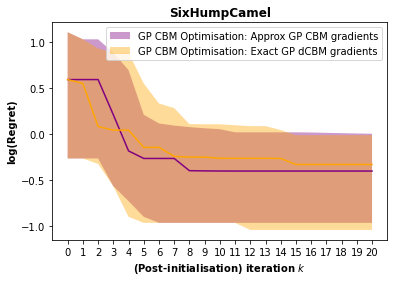

In [98]:
### Visualise!

title = func
plt.figure()

plt.plot(median_approx, color = 'Purple')
plt.plot(median_exact, color = 'Orange')

xstar = np.arange(0, iters+1, step=1)
plt.fill_between(xstar, lower_approx, upper_approx, facecolor = 'Purple', alpha=0.4, label='GP CBM Optimisation: Approx GP CBM gradients')
plt.fill_between(xstar, lower_exact, upper_exact, facecolor = 'Orange', alpha=0.4, label='GP CBM Optimisation: Exact GP dCBM gradients')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialisation) iteration $\it{k}$', weight = 'bold')
plt.ylabel('log(Regret)', weight = 'bold') 
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(0, count))
plt.show() #visualise!

In [99]:
time_approx, time_exact


(696.6064054965973, 662.0520279407501)

In [100]:
### acqFunc attribute x, stddev: run number = 1

acqFuncApprox_exact_1 = acqFuncApprox(exact_1.history)
acqFuncExact_exact_1 = acqFuncExact(exact_1.history)

e1 = np.std(acqFuncExact_exact_1)
a1 = np.std(acqFuncApprox_exact_1)

e1, a1


(0.21610424448419685, 0.3248523892533593)

In [101]:
### acqFunc attribute x, stddev: run number = 2

acqFuncApprox_exact_2 = acqFuncApprox(exact_2.history)
acqFuncExact_exact_2 = acqFuncExact(exact_2.history)

e2 = np.std(acqFuncExact_exact_2)
a2 = np.std(acqFuncApprox_exact_2)

e2, a2


(0.20727899803766686, 0.2612932345925214)

In [102]:
### acqFunc attribute x, stddev: run number = 3

acqFuncApprox_exact_3 = acqFuncApprox(exact_3.history)
acqFuncExact_exact_3 = acqFuncExact(exact_3.history)

e3 = np.std(acqFuncExact_exact_3)
a3 = np.std(acqFuncApprox_exact_3)

e3, a3


(0.15129014734893614, 0.17473118347930233)

In [103]:
### acqFunc attribute x, stddev: run number = 4

acqFuncApprox_exact_4 = acqFuncApprox(exact_4.history)
acqFuncExact_exact_4 = acqFuncExact(exact_4.history)

e4 = np.std(acqFuncExact_exact_4)
a4 = np.std(acqFuncApprox_exact_4)

e4, a4


(0.23847052136992092, 0.2601969656049746)

In [104]:
### acqFunc attribute x, stddev: run number = 5

acqFuncApprox_exact_5 = acqFuncApprox(exact_5.history)
acqFuncExact_exact_5 = acqFuncExact(exact_5.history)

e5 = np.std(acqFuncExact_exact_5)
a5 = np.std(acqFuncApprox_exact_5)

e5, a5


(0.32671594790433023, 0.4174732791650403)

In [105]:
### acqFunc attribute x, stddev: run number = 6

acqFuncApprox_exact_6 = acqFuncApprox(exact_6.history)
acqFuncExact_exact_6 = acqFuncExact(exact_6.history)

e6 = np.std(acqFuncExact_exact_6)
a6 = np.std(acqFuncApprox_exact_6)

e6, a6


(0.21043641162813392, 0.12107984386398167)

In [106]:
### acqFunc attribute x, stddev: run number = 7

acqFuncApprox_exact_7 = acqFuncApprox(exact_7.history)
acqFuncExact_exact_7 = acqFuncExact(exact_7.history)

e7 = np.std(acqFuncExact_exact_7)
a7 = np.std(acqFuncApprox_exact_7)

e7, a7


(0.18332960395239634, 0.18079874697153236)

In [107]:
### acqFunc attribute x, stddev: run number = 8

acqFuncApprox_exact_8 = acqFuncApprox(exact_8.history)
acqFuncExact_exact_8 = acqFuncExact(exact_8.history)

e8 = np.std(acqFuncExact_exact_8)
a8 = np.std(acqFuncApprox_exact_8)

e8, a8


(0.15094646760734912, 0.2680265824810942)

In [108]:
### acqFunc attribute x, stddev: run number = 9

acqFuncApprox_exact_9 = acqFuncApprox(exact_9.history)
acqFuncExact_exact_9 = acqFuncExact(exact_9.history)

e9 = np.std(acqFuncExact_exact_9)
a9 = np.std(acqFuncApprox_exact_9)

e9, a9


(0.21176456821079803, 0.22995878889974283)

In [109]:
### acqFunc attribute x, stddev: run number = 10

acqFuncApprox_exact_10 = acqFuncApprox(exact_10.history)
acqFuncExact_exact_10 = acqFuncExact(exact_10.history)

e10 = np.std(acqFuncExact_exact_10)
a10 = np.std(acqFuncApprox_exact_10)

e10, a10


(0.11483478946189472, 0.23398665385292414)

In [110]:
### acqFunc attribute x, stddev: run number = 11

acqFuncApprox_exact_11 = acqFuncApprox(exact_11.history)
acqFuncExact_exact_11 = acqFuncExact(exact_11.history)

e11 = np.std(acqFuncExact_exact_11)
a11 = np.std(acqFuncApprox_exact_11)

e11, a11


(0.21372594193472294, 0.20059730622504646)

In [111]:
### acqFunc attribute x, stddev: run number = 12

acqFuncApprox_exact_12 = acqFuncApprox(exact_12.history)
acqFuncExact_exact_12 = acqFuncExact(exact_12.history)

e12 = np.std(acqFuncExact_exact_12)
a12 = np.std(acqFuncApprox_exact_12)

e12, a12


(0.28914822174369853, 0.22150043824586554)

In [112]:
### acqFunc attribute x, stddev: run number = 13

acqFuncApprox_exact_13 = acqFuncApprox(exact_13.history)
acqFuncExact_exact_13 = acqFuncExact(exact_13.history)

e13 = np.std(acqFuncExact_exact_13)
a13 = np.std(acqFuncApprox_exact_13)

e13, a13


(0.211833495316369, 0.31031709120998413)

In [113]:
### acqFunc attribute x, stddev: run number = 14

acqFuncApprox_exact_14 = acqFuncApprox(exact_14.history)
acqFuncExact_exact_14 = acqFuncExact(exact_14.history)

e14 = np.std(acqFuncExact_exact_14)
a14 = np.std(acqFuncApprox_exact_14)

e14, a14


(0.13730072173033617, 0.20969278069254751)

In [114]:
### acqFunc attribute x, stddev: run number = 15

acqFuncApprox_exact_15 = acqFuncApprox(exact_15.history)
acqFuncExact_exact_15 = acqFuncExact(exact_15.history)

e15 = np.std(acqFuncExact_exact_15)
a15 = np.std(acqFuncApprox_exact_15)

e15, a15


(0.1574957310736061, 0.2108997973366306)

In [115]:
### acqFunc attribute x, stddev: run number = 16

acqFuncApprox_exact_16 = acqFuncApprox(exact_16.history)
acqFuncExact_exact_16 = acqFuncExact(exact_16.history)

e16 = np.std(acqFuncExact_exact_16)
a16 = np.std(acqFuncApprox_exact_16)

e16, a16


(0.4866455802145649, 0.45937208140679686)

In [116]:
### acqFunc attribute x, stddev: run number = 17

acqFuncApprox_exact_17 = acqFuncApprox(exact_17.history)
acqFuncExact_exact_17 = acqFuncExact(exact_17.history)

e17 = np.std(acqFuncExact_exact_17)
a17 = np.std(acqFuncApprox_exact_17)

e17, a17


(0.19588198298445603, 0.25666875678768436)

In [117]:
### acqFunc attribute x, stddev: run number = 18

acqFuncApprox_exact_18 = acqFuncApprox(exact_18.history)
acqFuncExact_exact_18 = acqFuncExact(exact_18.history)

e18 = np.std(acqFuncExact_exact_18)
a18 = np.std(acqFuncApprox_exact_18)

e18, a18


(0.13276296258567524, 0.15131895954037344)

In [118]:
### acqFunc attribute x, stddev: run number = 19

acqFuncApprox_exact_19 = acqFuncApprox(exact_19.history)
acqFuncExact_exact_19 = acqFuncExact(exact_19.history)

e19 = np.std(acqFuncExact_exact_19)
a19 = np.std(acqFuncApprox_exact_19)

e19, a19


(0.19878852996697693, 0.22751681120133826)

In [119]:
### acqFunc attribute x, stddev: run number = 20

acqFuncApprox_exact_20 = acqFuncApprox(exact_20.history)
acqFuncExact_exact_20 = acqFuncExact(exact_20.history)

e20 = np.std(acqFuncExact_exact_20)
a20 = np.std(acqFuncApprox_exact_20)

e20, a20


(0.19692639279508953, 0.17585558773892274)

In [120]:
### Summarize arrays: 

exact_stddev = np.sort([e1,e2,e3,e4,e5,e6,e7,e8,e9,e10,e11,e12,e13,e14,e15,e16,e17,e18,e19,e20])
approx_stddev = np.sort([a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,a18,a19,a20])

np.mean(exact_stddev), np.mean(approx_stddev)


(0.21158406301755592, 0.2448068639274832)

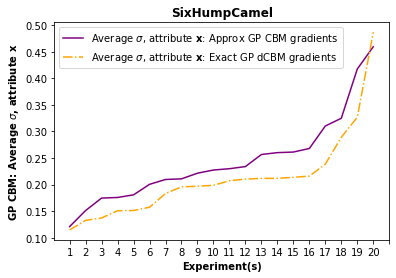

In [121]:
### Visualise!

title = func
plt.figure()

plt.plot(approx_stddev, color = 'Purple', ls='-', label='Average $\sigma$, attribute $\mathbf{x}$: Approx GP CBM gradients')
plt.plot(exact_stddev, color = 'Orange', ls='-.', label='Average $\sigma$, attribute $\mathbf{x}$: Exact GP dCBM gradients')

plt.title(title, weight = 'bold')
plt.xlabel('Experiment(s)', weight = 'bold')
plt.ylabel('GP CBM: Average $\sigma$, attribute $\mathbf{x}$', weight = 'bold') 
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count))
plt.show() #visualize!
